In [81]:
import numpy as np
from scipy.optimize import minimize

class KalmanFilter:
    def __init__(self, measurement_matrix, Q, R, initial_state, initial_covariance):
        self.measurement_matrix = measurement_matrix
        self.Q = Q
        self.R = R
        self.state = initial_state
        self.covariance = initial_covariance

    def filter(self, data):
        predicted_diff = np.zeros((len(data), 1))
        for t in range(len(data)):
            # Construct the measurement vector
            y = np.array([data[t, 0], data[t, 1]])
            measurement_vector = self.measurement_matrix @ y.reshape(-1, 1)

            # Prediction step
            state_minus = self.state
            covariance_minus = self.covariance + self.Q

            # Update step
            K = covariance_minus @ self.measurement_matrix.T @ np.linalg.inv(self.measurement_matrix @ covariance_minus @ self.measurement_matrix.T + self.R)
            self.state = state_minus + K @ (measurement_vector - self.measurement_matrix @ state_minus)
            self.covariance = (np.eye(2) - K @ self.measurement_matrix) @ covariance_minus

            predicted_diff[t] = self.measurement_matrix @ self.state
        return predicted_diff

def optimize_kalman_filter(data, measurement_matrix, initial_state, initial_covariance):
    # Define the objective function to minimize
    def objective(x):
        Q = np.diag(x[:2])
        R = x[2]
        kf = KalmanFilter(measurement_matrix=measurement_matrix, Q=Q, R=R, initial_state=initial_state, initial_covariance=initial_covariance)
        predicted_diff = kf.filter(data)
        residuals = predicted_diff - data[:, 2]
        return np.sum(residuals ** 2)

    # Define the initial guess for Q and R
    x0 = np.array([1.0, 1.0, 1.0])

    # Minimize the objective function
    result = minimize(objective, x0)

    # Get the optimized Q and R values
    Q_opt = np.diag(result.x[:2])
    R_opt = result.x[2]

    return Q_opt, R_opt

measurement_matrix = np.array([[1, 0]])
# Set the initial state and covariance
initial_state = np.array([[y[0]], [0]])
initial_covariance = np.eye(2)

Q_opt, R_opt = optimize_kalman_filter(ddd, measurement_matrix, initial_state, initial_covariance)


IndexError: index 2 is out of bounds for axis 1 with size 2

In [79]:
from scipy.optimize import minimize

def optimize_kalman_filter(data, measurement_matrix, initial_state, initial_covariance):
    # Define the objective function to minimize
    def objective(x):
        Q = np.diag(x[:2])
        R = x[2]
        kf = KalmanFilter(measurement_matrix=measurement_matrix, Q=Q, R=R, initial_state=initial_state, initial_covariance=initial_covariance)
        predicted_diff = kf.filter(data)
        residuals = predicted_diff - data[:, 2]
        return np.sum(residuals ** 2)

    # Define the initial guess for Q and R
    x0 = np.array([1.0, 1.0, 1.0])

    # Minimize the objective function
    result = minimize(objective, x0)

    # Get the optimized Q and R values
    Q_opt = np.diag(result.x[:2])
    R_opt = result.x[2]

    return Q_opt, R_opt

measurement_matrix = np.array([[1, 0]])
# Set the initial state and covariance
initial_state = np.array([[y[0]], [0]])
initial_covariance = np.eye(2)

Q_opt, R_opt = optimize_kalman_filter(ddd, measurement_matrix, initial_state, initial_covariance)


IndexError: index 2 is out of bounds for axis 1 with size 2

[*********************100%***********************]  2 of 2 completed


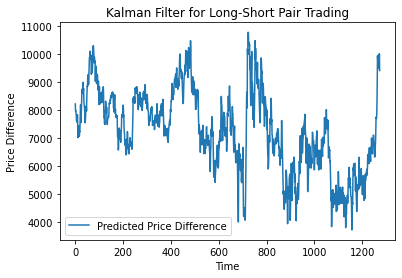

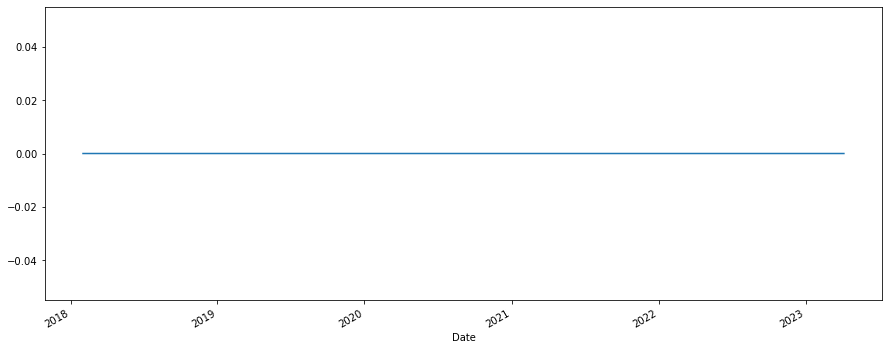

In [50]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Load the price data for two stocks

# semiconduct = ["005930.KS",'000660.KS']
# cars = ["005380.KS","000270.KS"]
# construction =  ["000720.KS",'006360.KS']


# tickers = ["000720.KS",'006360.KS']
# df = yf.download(tickers,'2010-2-1','2023-3-24')['Adj Close']


def kf(data):
    
    if not isinstance(data, np.ndarray):
        price_data = np.array(data)
    else:
        price_data = data
    
    #price_data = np.log(price_data)
    
    # Set the measurement matrix 
    # 측정 방법을 나타냄. 변수 x,y 를 어떤 가중치로 조합하여 측정할지
    # 여기서는 둘 사이의 Spread 차이를 보고 싶었기 때문에 x - y 의 가중치인 [1, -1] 로 하였음
    measurement_matrix = np.array([[1, -1]])

    # Set the process noise and measurement noise covariances
    Q = 0.01 * np.eye(2)  # 프로세스 노이즈의 공분산 행렬
    R = 0.01   # 측정노이즈의 분산 # 측정장비가 정확하면 큰값으로, 그렇지 않을 경우 작은 값으로

    # Set the initial state estimate and covariance matrix
    x_hat = np.zeros((2, 1))
    P = np.eye(2)

    # Run the Kalman filter
    predicted_diff = np.zeros((len(price_data), 1))
    for t in range(len(price_data)):
        # Construct the measurement vector
        y = np.array([price_data[t, 0], price_data[t, 1]])
        measurement_vector = measurement_matrix @ y.reshape(-1, 1)

        # Prediction step
        x_hat_minus = x_hat
        P_minus = P + Q

        # Update step
        # 예측된 상태의 오차 공분산, 측정방법, 
        K = P_minus @ measurement_matrix.T @ np.linalg.inv(measurement_matrix @ P_minus @ measurement_matrix.T + R)
        x_hat = x_hat_minus + K @ (measurement_vector - measurement_matrix @ x_hat_minus)
        P = (np.eye(2) - K @ measurement_matrix) @ P_minus

        predicted_diff[t] = measurement_matrix @ x_hat
    
    return predicted_diff
def plot_predicted(predicted_diff):
    # Plot the predicted price difference
    plt.plot(predicted_diff, label='Predicted Price Difference')
    plt.legend()
    plt.title('Kalman Filter for Long-Short Pair Trading')
    plt.xlabel('Time')
    plt.ylabel('Price Difference')
    plt.show()
    return


def ls_backtest(df, predicted_diff, Window, Open_pos, Close_pos):
    temp_df = df
    tickers = list(df.columns)
    df_index = df.index
    
    df = df.dropna()
    
    if not isinstance(df, np.ndarray):
        price_data = np.array(df)
    else:
        price_data = df
        
    # 수정
#     price_data = price_data.dropna()

    # Set the threshold for prediction error
    window = Window
    open_pos = Open_pos
    close_pos = Close_pos
    threshold = (-pd.DataFrame(price_data).diff(axis=1).iloc[:,1]).rolling(window).std() 
    commission_rate = 0.005

    # Use the predicted price difference to trade the two stocks

    prices1 = price_data[:, 0]
    prices2 = price_data[:, 1]
    units = pd.DataFrame(index=df_index, columns=tickers).fillna(0)

    for t in threshold.dropna().index:
        # Calculate the current price difference
        diff = prices1[t] - prices2[t]
        # Use the predicted price difference to determine the trading position
        if predicted_diff[t] - diff >  open_pos * threshold[t]:
            # 괴리가 너무 벌어지면 포지션 청산
            if predicted_diff[t] - diff > close_pos * threshold[t]:
                units.iloc[t] = [0, 0]
            else:
                # Buy stock 1 and sell stock 2
                units.iloc[t] = [0.5 * (1 - commission_rate), -0.5 * (1 - commission_rate)]

        elif predicted_diff[t] - diff < - open_pos * threshold[t]:
            # 괴리가 너무 벌어지면 포지션 청산
            if predicted_diff[t] - diff < - close_pos * threshold[t]:
                units.iloc[t] = [0, 0]
            else:
                # Sell stock 1 and bouy stock 2
                units.iloc[t] = [-0.5 * (1 - commission_rate), 0.5 * (1 - commission_rate)]
        else:
            # Hold current position
            units.iloc[t] = [0, 0]
            
#         if units.iloc[t,0] != units.iloc[t,1]:
#             trades +=1
            
    # Calculate the final portfolio value
    total = ((np.log(pd.DataFrame(price_data, columns=tickers, index =df_index )).diff()) * (units.shift(1))).sum(axis=1).cumsum()
    total.index = df_index
    return total , units

def ls_backtest_add_parameter(df):
    predicted_diff = kf(df)
    
    # Grid search for optimal parameters
    best_return = -np.inf
    best_params = (0, 0 , 0)
    for window in range(10, 41, 5):
        for open_pos in  np.arange(0.5, 1.5, 0.2):
            for close_pos in range(1, 6):
                total , _ = ls_backtest(df, predicted_diff, window, open_pos, close_pos)
                ret = total.iloc[-1]
                if ret > best_return:
                    best_return = ret
                    best_params = (window, open_pos, close_pos)

    # Print the best parameters and return
    print(f"Best parameters: Window={best_params[0]}, Open_pos={best_params[1]}, close_pos = {best_params[2]}")
    print(f"Best return: {round(best_return,3)}")
    cagr = (best_return+1)**(1/((total.index[-1] -total.index[0]).days/365))-1
    print(f"CAGR : {round(cagr,3)}")
    
    # Plot the portfolio value with the best parameters
    total , _= ls_backtest(df, predicted_diff, best_params[0], best_params[1] , best_params[2])
    total.plot(figsize=(15,6))
    return total, best_params[0], best_params[1] , best_params[2]



if __name__ == "__main__":
    tickers = ['005930.KS','005935.KS']
    df = yf.download(tickers,'2018-2-1','2023-4-7')['Adj Close']
    predicted_diff = kf(df)
    plot_predicted(predicted_diff)
    total, units = ls_backtest(df,predicted_diff, 20 , 1, 2.5)
    total.plot(figsize=(15,6))

In [36]:
df

L&F     Ecobm
Date                        
2019-03-05  186224   15616.0
2019-03-06  187112   16975.0
2019-03-07  183564   17296.0
2019-03-08  182678   17271.0
2019-03-11  181791   17098.0
...            ...       ...
2023-04-04  159000  224500.0
2023-04-05  158600  235000.0
2023-04-06  159500  247500.0
2023-04-07  159500  257500.0
2023-04-10  163900  292500.0

[1016 rows x 2 columns]

In [5]:
import pandas_datareader as pdr
code = ['068270.KS','247540.KQ']
df = pdr.get_data_yahoo(code)

TypeError: string indices must be integers

In [37]:
import FinanceDataReader as fdr

# 엘엔에프(068270)와 에코프로비엠(247540)의 가격 데이터 가져오기
eln = fdr.DataReader('066970', '2019-01-01', '2023-04-10')['Close']
ep = fdr.DataReader('247540', '2019-01-01', '2023-04-10')['Close']

In [38]:
df =pd.concat([eln,ep],axis=1).dropna()

In [2]:
# 코스피, 코스닥 가져오기

# start_date = "20100101"
# end_date = "20230328"

# kospi = stock.get_index_portfolio_deposit_file("1001")
# kosdaq =stock.get_index_portfolio_deposit_file("2001")

# df_kospi = get_price_krx(kospi, start_date, end_date)
# df_kosdaq = get_price_krx(kosdaq, start_date, end_date)

# df_krx = pd.concat([df_kosdaq,df_kospi],axis=1)

#df_krx = pd.read_excel("C:/Users/seongsh/ML/krx_price.xlsx", index_col = 0)

In [3]:
from pykrx import stock
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import coint

## KOSPI 200 데이터 가져오기

kospi200_list = stock.get_index_portfolio_deposit_file("1028")


def get_price_krx(codes, start_date, end_date):
    # 각 종목의 시계열 데이터 가져오기
    dfs = []
    for code in codes:
        df = stock.get_market_ohlcv_by_date(start_date, end_date, code)
        df = df[['종가']]
        df.columns = [code]
        dfs.append(df)

    # 데이터 병합
    df_all = pd.concat(dfs, axis=1)
    df_all.head()
    return df_all

#df_all = get_price_krx(kospi200_list, "20150101","20230327")

# 코스피 200 시계열 데이터를 가지고 표준화 해주기



# 1. 상관계수가 일정수준 이상인 pair를 찾음
def get_high_corr_stock(df):
    
    # 표준화
    df.dropna()
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df),columns = df.columns,index = df.index)

    ## 표준화된 데이터를 가지고 상관계수를 측정하고
    df_corr = df_scaled.corr()
    
  
    pair = []

    for i in range(len(df_corr)):
        for j in range(i+1, len(df_corr)):
            if (df_corr.iloc[i,j] > 0.95) & (i!=j):
                pair.append(list(df_corr.columns[[i,j]].values))
    
    return pair

# 2. 상관계수가 높은 pair 중에서 cointegration의 P-value가 통계적으로 유의미한 수치를 보이는 경우를 찾아냄
def get_cointegration_stocks(df, pairs):

    ls_stocks = []

    for pair in pairs:
        temp = df[pair]
        temp = temp.dropna()
        # VAR 모형 생성
        statistic, pvalue, _ = coint(temp.iloc[:,0], temp.iloc[:,1])

        if pvalue<0.005:
            ls_stocks.append(pair)
    return ls_stocks

# pairs = get_high_corr_stock(df_all)
# ls_stocks = get_cointegration_stocks(df_all, pairs)

C:\Users\seongsh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\seongsh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [30]:
# DataFrame 가져오기
df_krx = pd.read_excel("C:/Users/seongsh/Desktop/py_rsc/krx_price.xlsx", index_col = 0)
# 칼럼에서 A를 빼버리기
df_krx.columns = df_krx.columns.str.replace("A","")
# 코드랑 이름 딕셔너리
Code_name = dict(df_krx.loc["Name"])
# Name 행을 빼버리기
df_krx = df_krx.drop(['Name'])
# 데이터가 없는 행 버리기
df_krx = df_krx.dropna(axis=0, how="all")
# object 에서 float로 바꿔주기
df_krx = df_krx.astype("float")

In [5]:
# 코스피 200종목 가져오기
kospi200_list = stock.get_index_portfolio_deposit_file("1028")

# 종목 코드를 종목명으로 변환하기
kospi200_name_list = [stock.get_market_ticker_name(code) for code in kospi200_list]

# 코스피 200과 관련있는 종목코드 추출하기
kospi200_add_preferred = [code for code, name in Code_name.items() if any(name.startswith(n) for n in kospi200_name_list)]

# 관련종목들을 넣기
df2 = df_krx[kospi200_add_preferred]

In [6]:
new_pairs = []
pairs = get_high_corr_stock(df2)
for pair in pairs:
    temp = df2[pair]
    temp = temp.dropna()
    predicted_spread = kf(temp)
    price1 = temp.iloc[:,0]
    price2 = temp.iloc[:,1]
    real_spread = price1- price2
    statistic, pvalue, _  = coint(predicted_spread, real_spread)
    if pvalue < 0.005:
        new_pairs.append(pair)

C:\Users\seongsh\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\seongsh\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


In [7]:
possible_stocks = list(df2.iloc[-1].dropna().index)

possible_new_pairs = [code for code in new_pairs if all(c in possible_stocks for c in code)]

In [8]:
class post_backtest:
    def __init__(self):
        pass
    def annualized_return(self, total):
        years = (total.index[-1] - total.index[0]).days / 365
        return (total.iloc[-1] / total.iloc[0])**(1/years) - 1

    def annualized_volatility(self, total):
        ann_vol = total.pct_change().std()*np.sqrt(52) # 현재는 주
        return ann_vol

    def sharpe_ratio(self, total, risk_free_rate=0.02):
        daily_returns = total.pct_change().dropna()
        excess_returns = daily_returns - risk_free_rate / 252
        return np.sqrt(252) * excess_returns.mean() / excess_returns.std()

    def max_drawdown(self, total):
        dd = (total/total.cummax())-1
        mdd = dd.min()
        return mdd

    def performance(self, total):
        ann_ret = self.annualized_return(total)
        ann_vol = self.annualized_volatility(total)
        mdd = self.max_drawdown(total)
        return ann_ret, ann_vol, mdd

In [9]:
a = post_backtest()

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


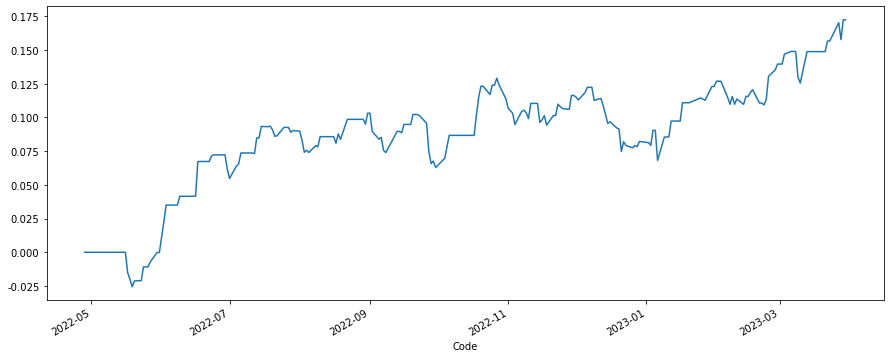

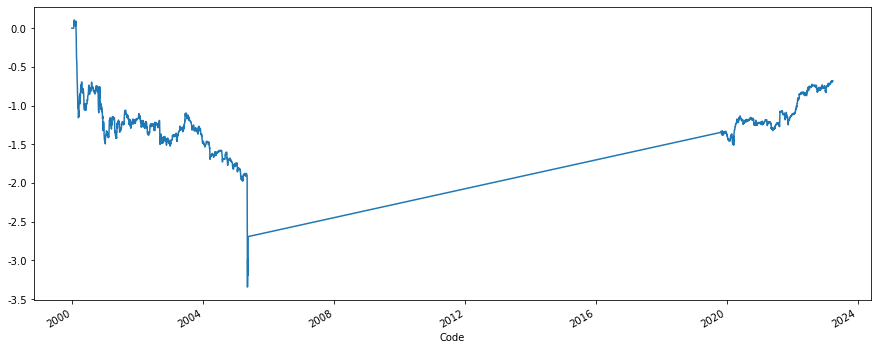

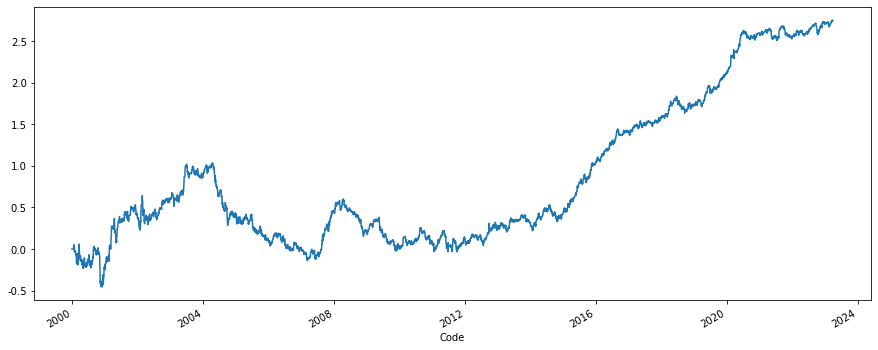

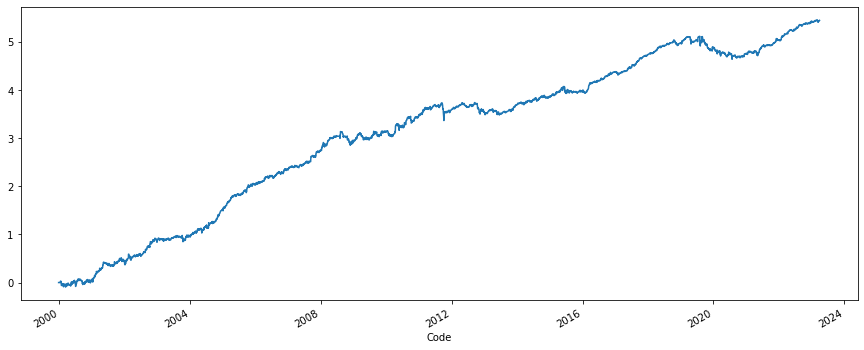

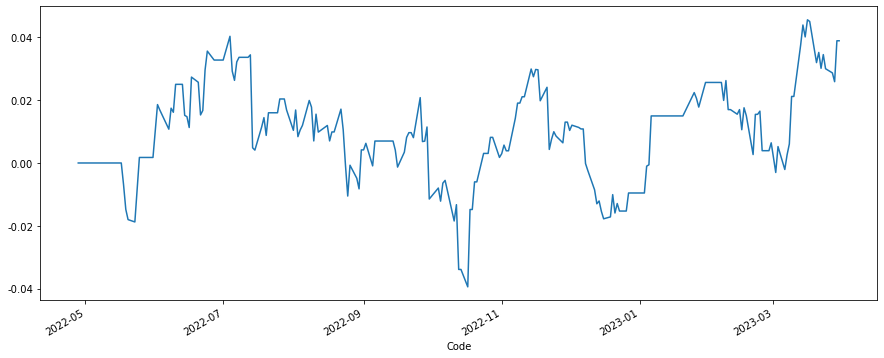

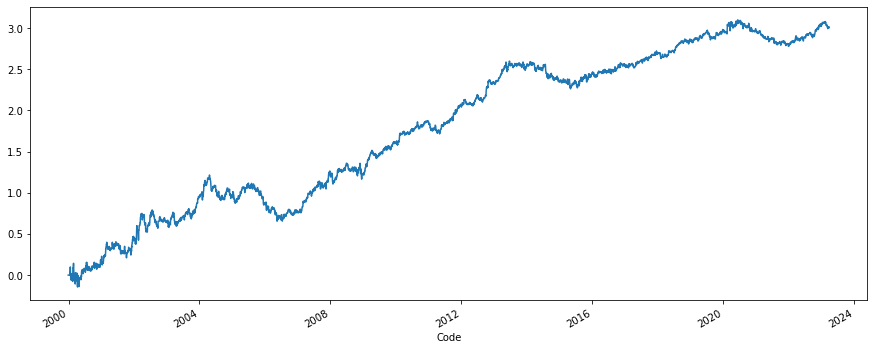

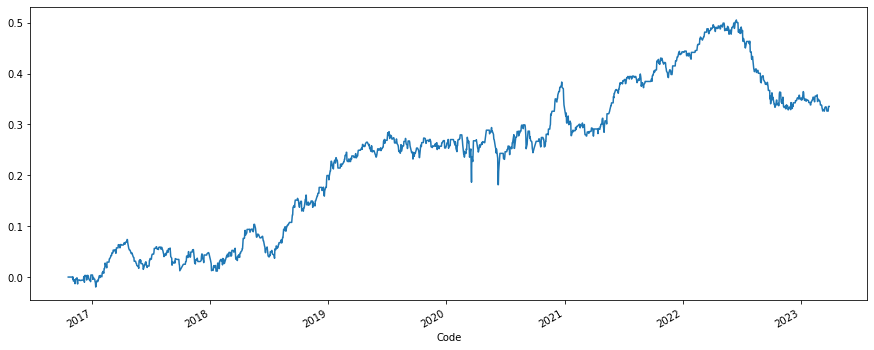

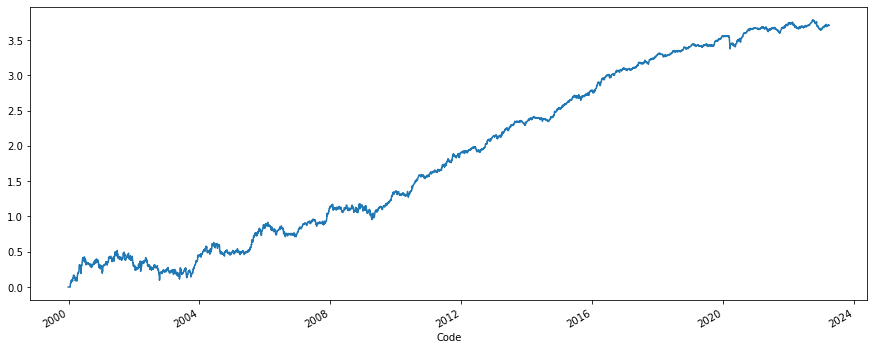

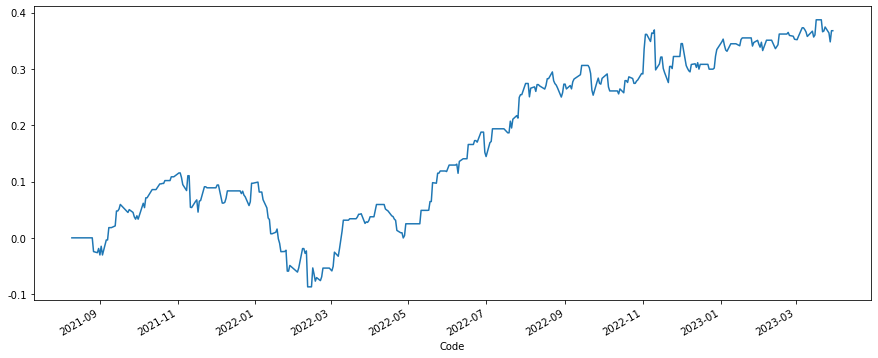

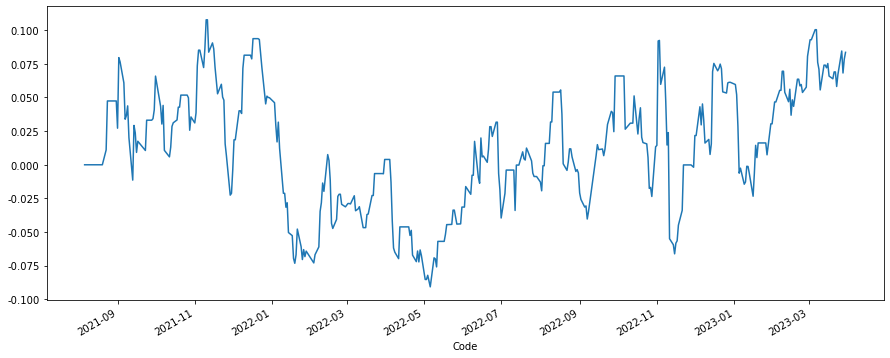

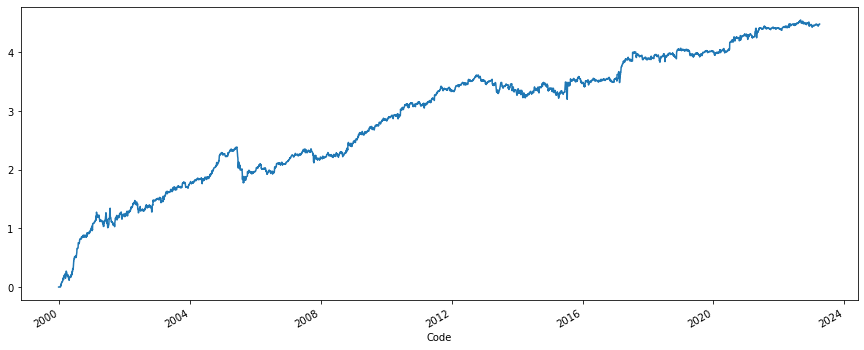

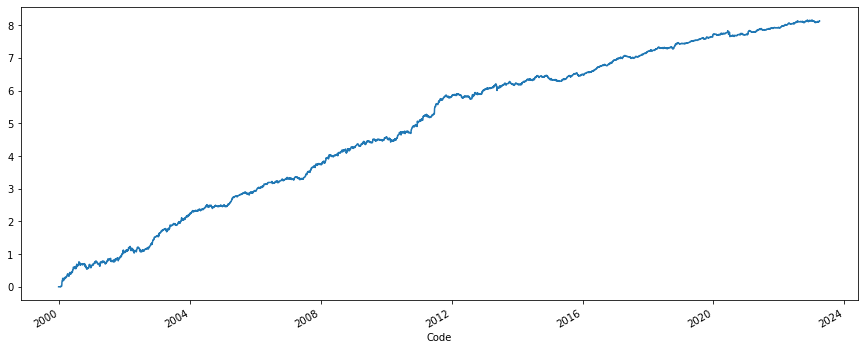

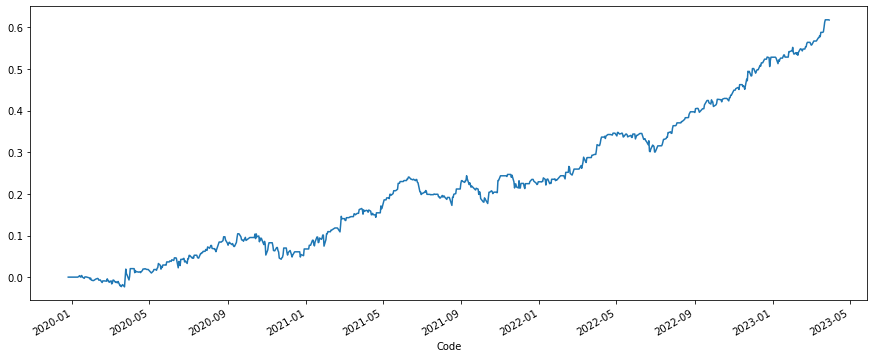

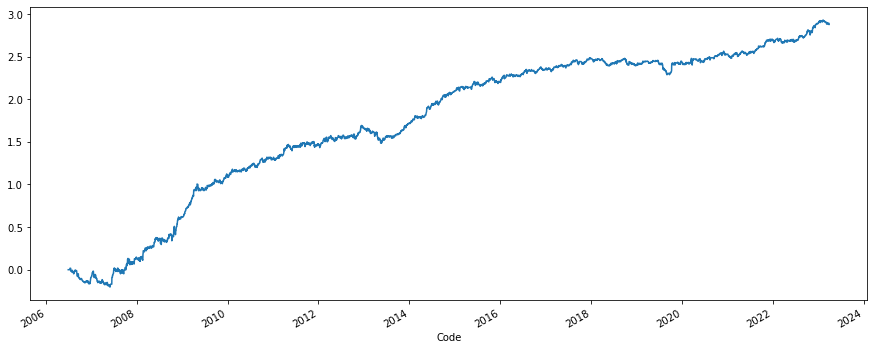

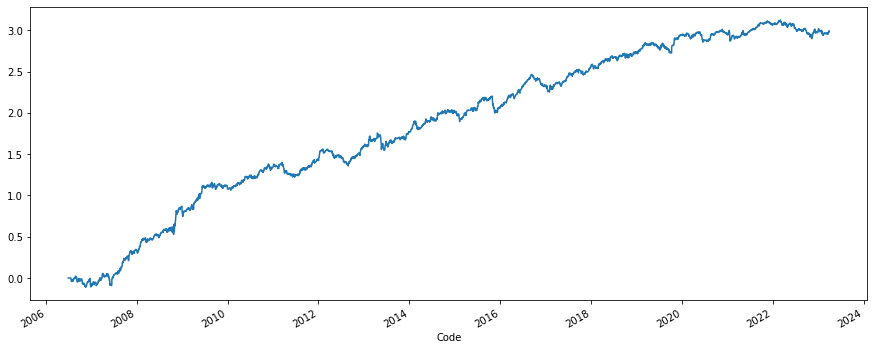

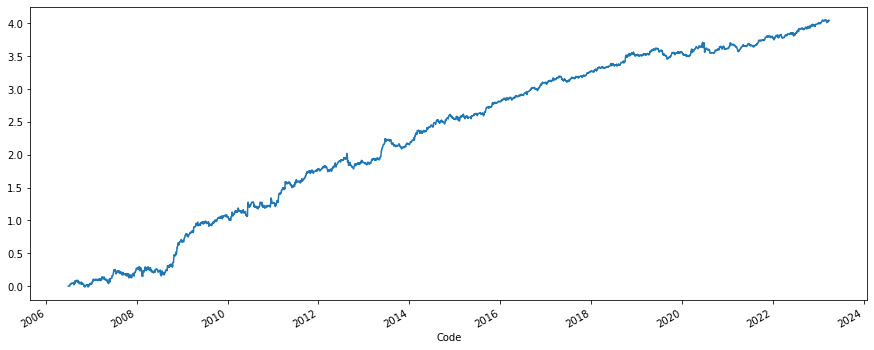

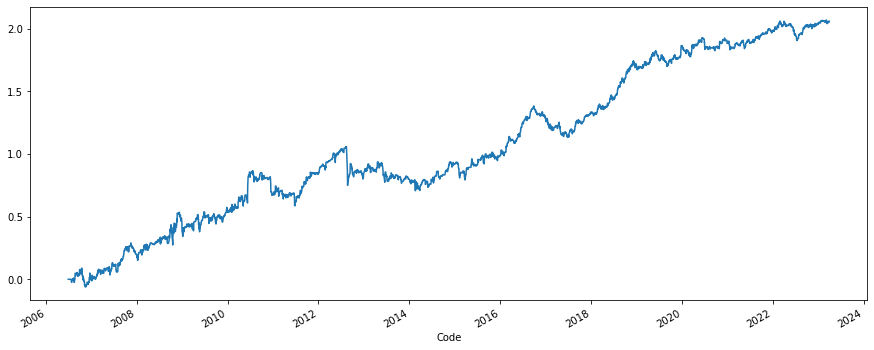

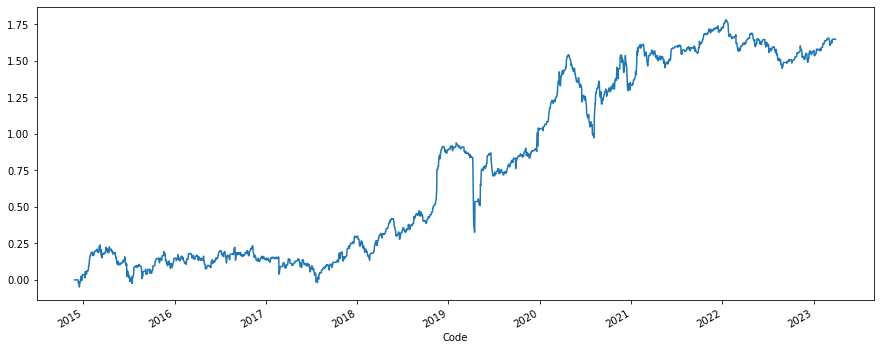

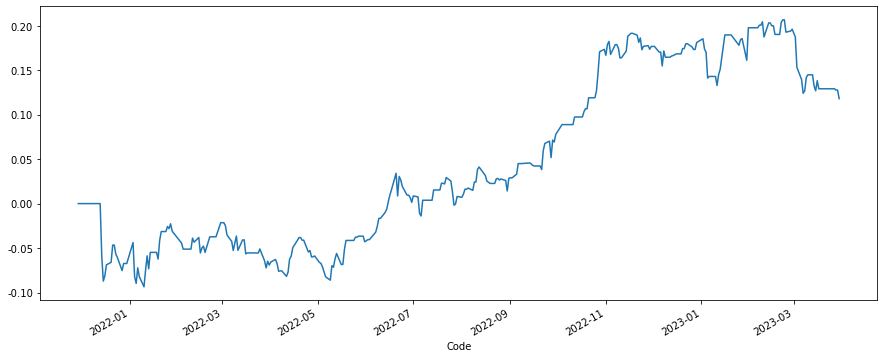

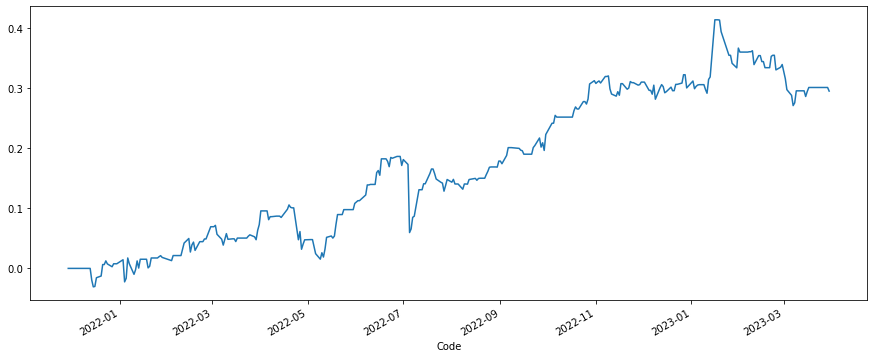

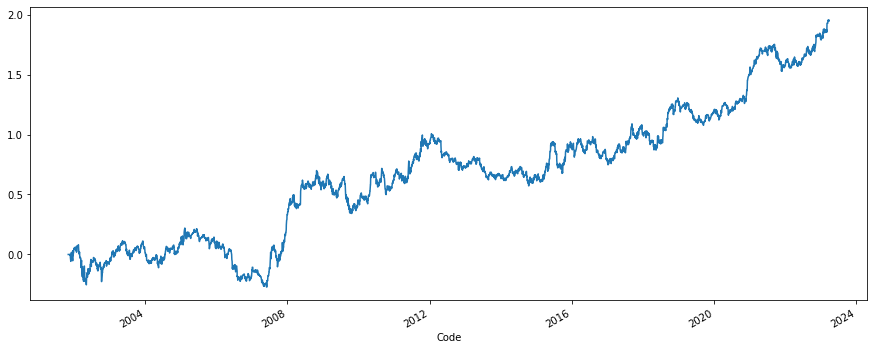

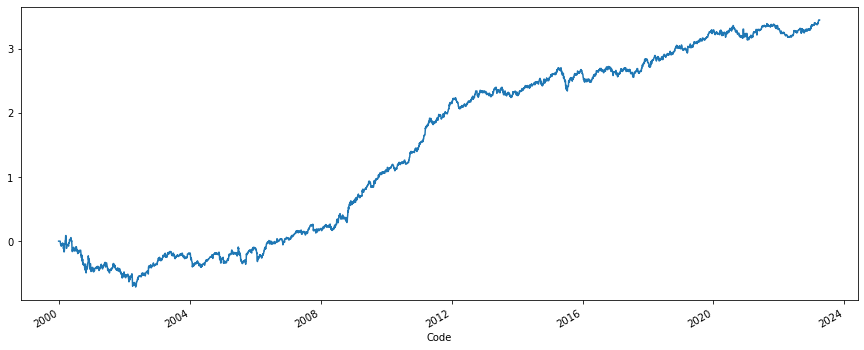

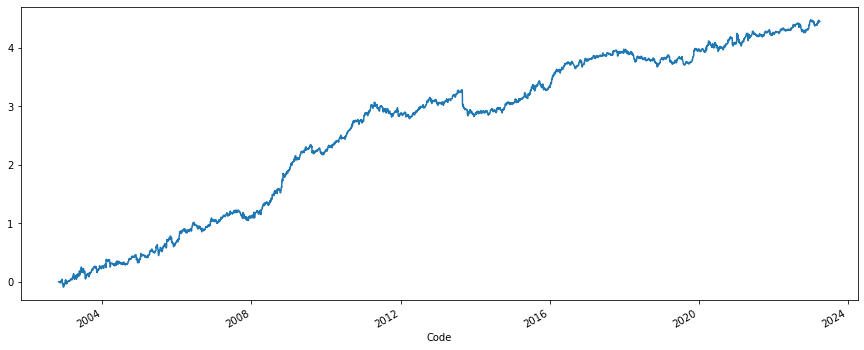

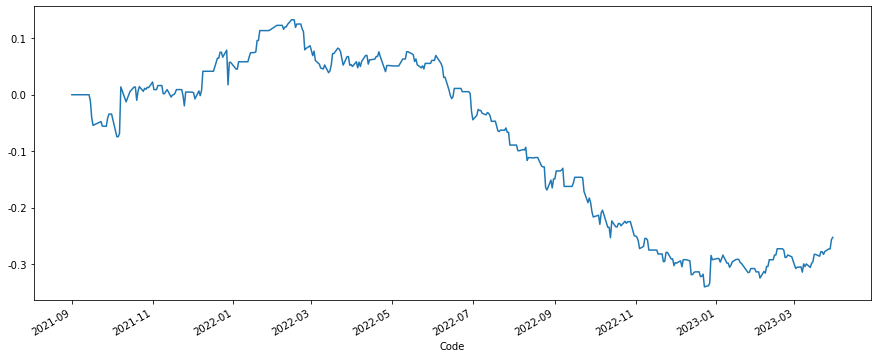

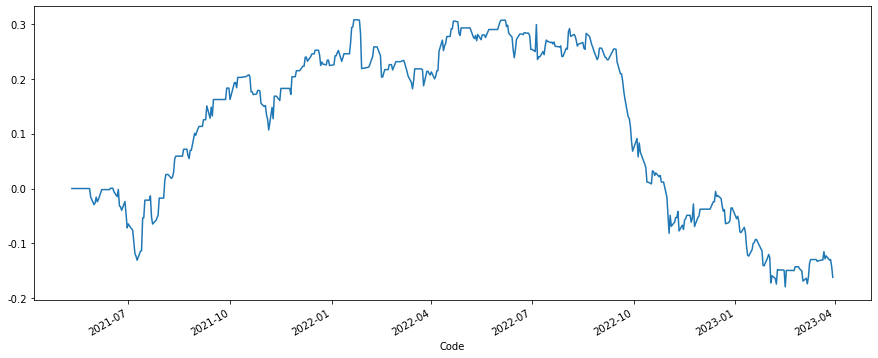

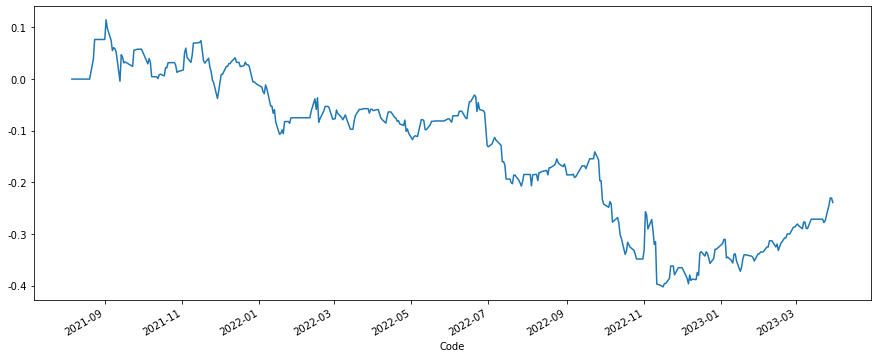

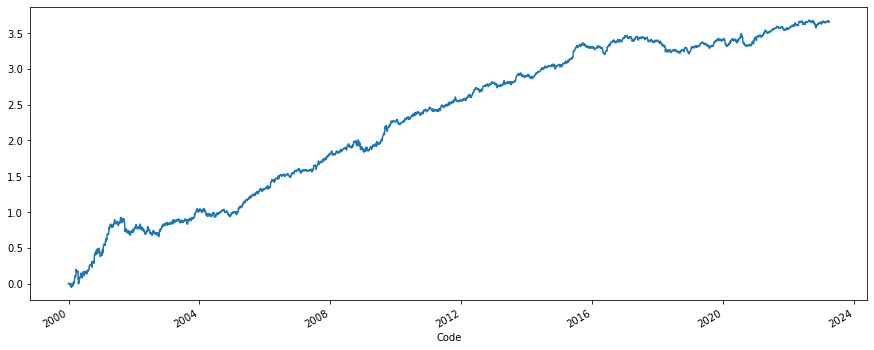

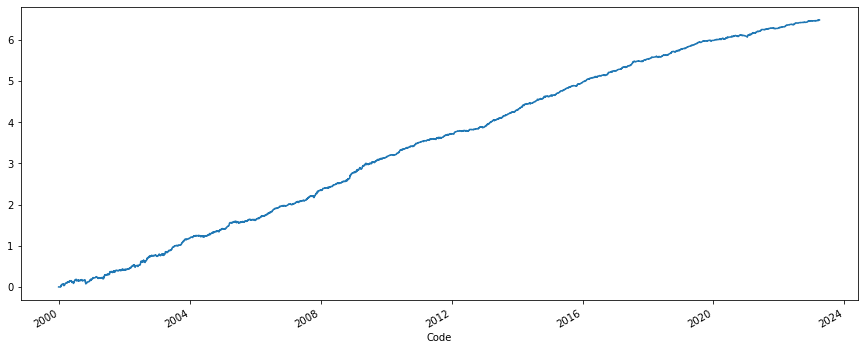

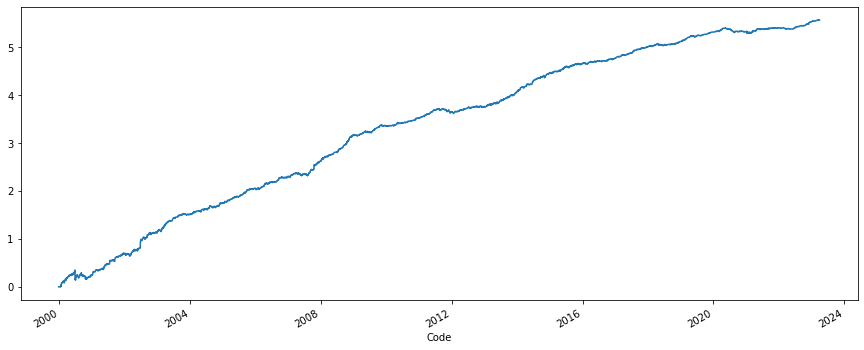

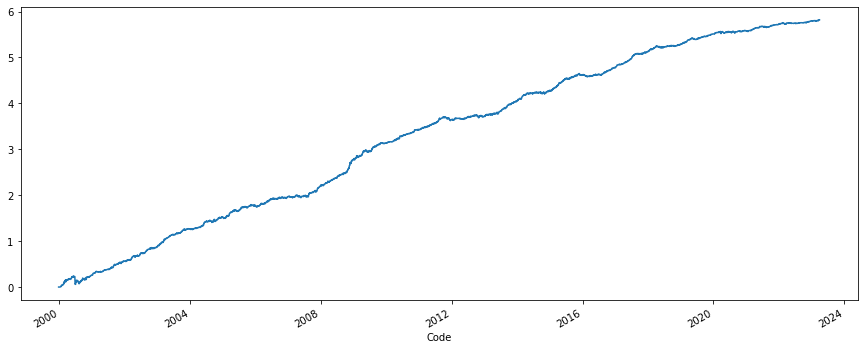

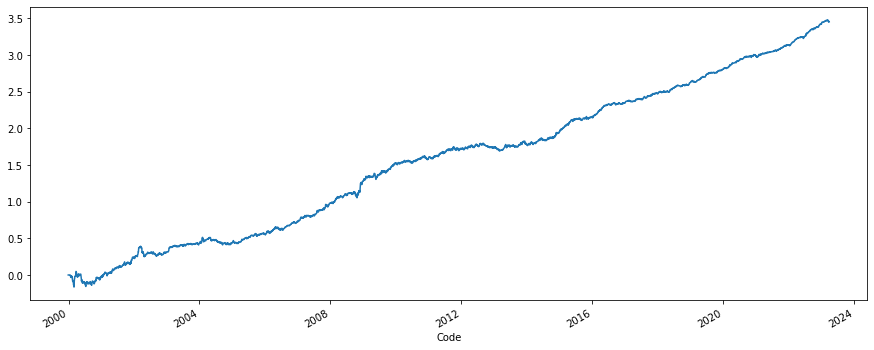

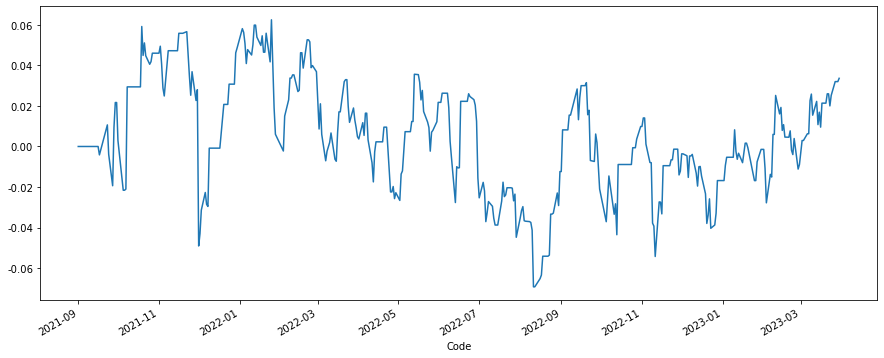

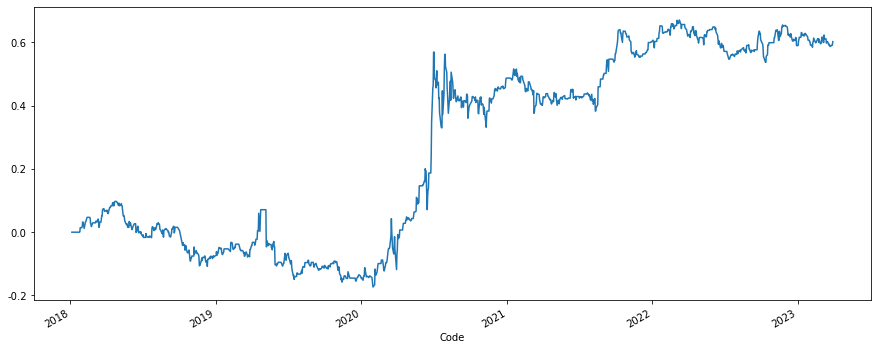

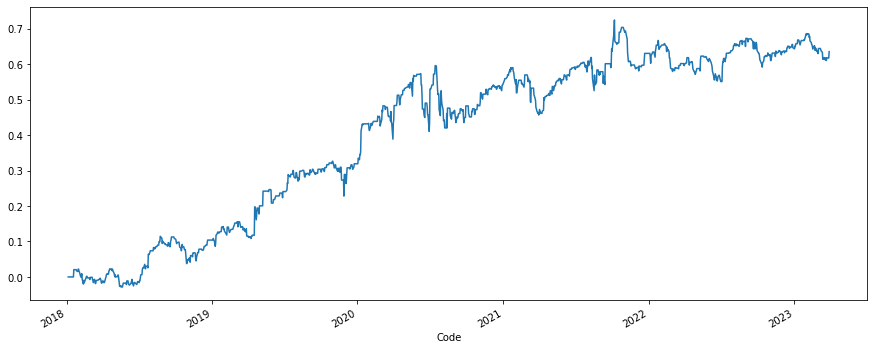

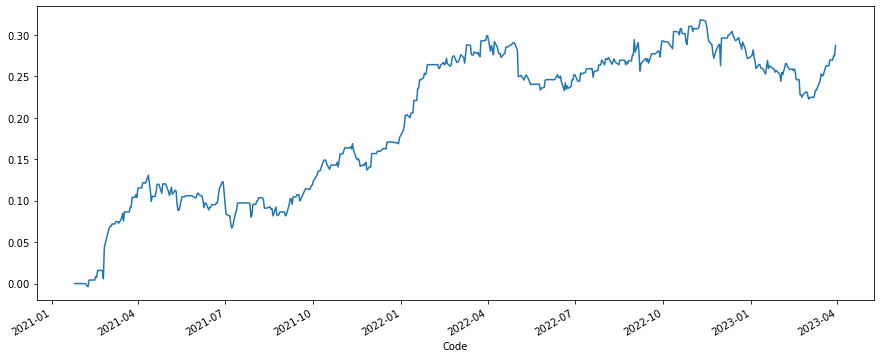

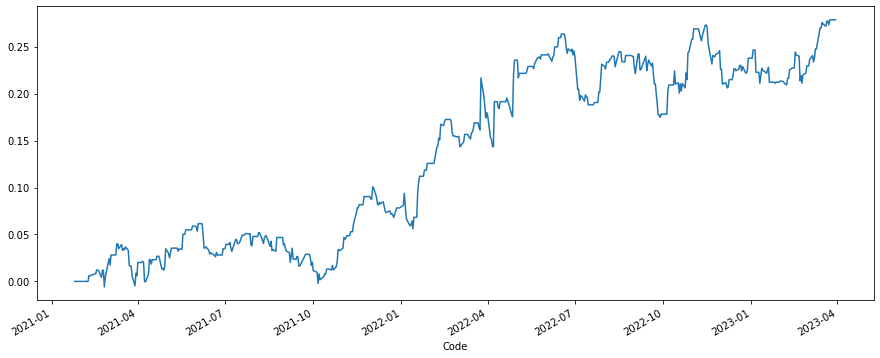

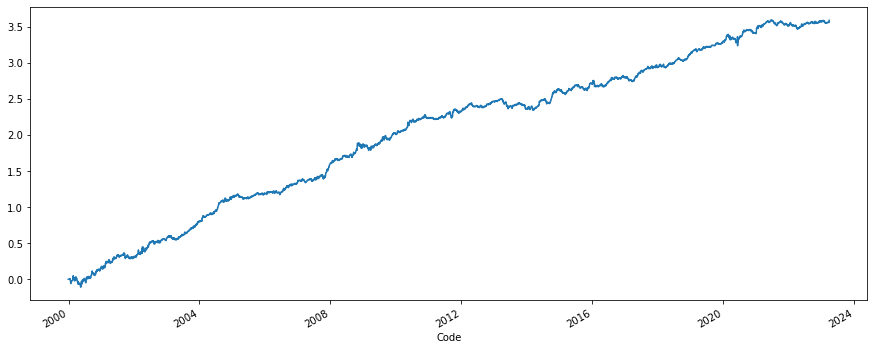

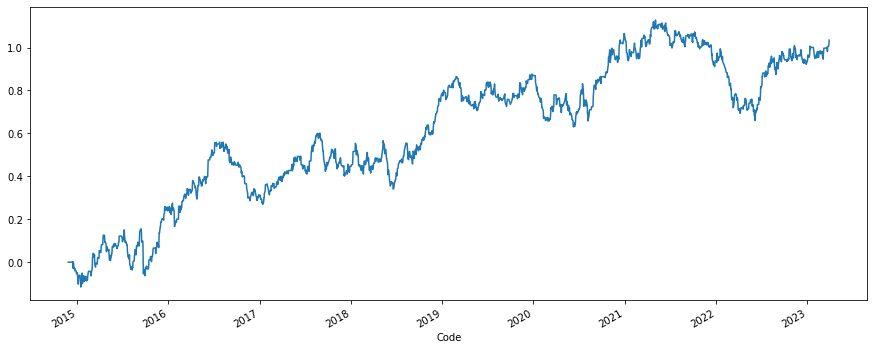

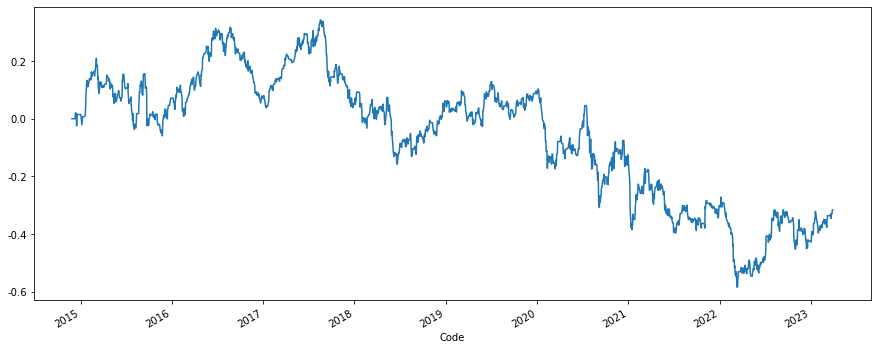

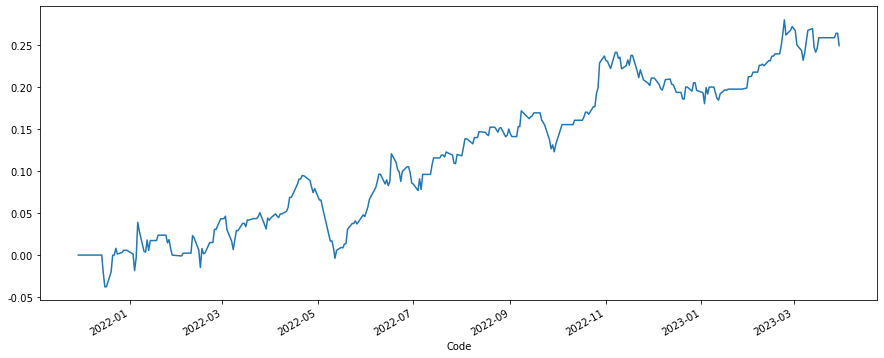

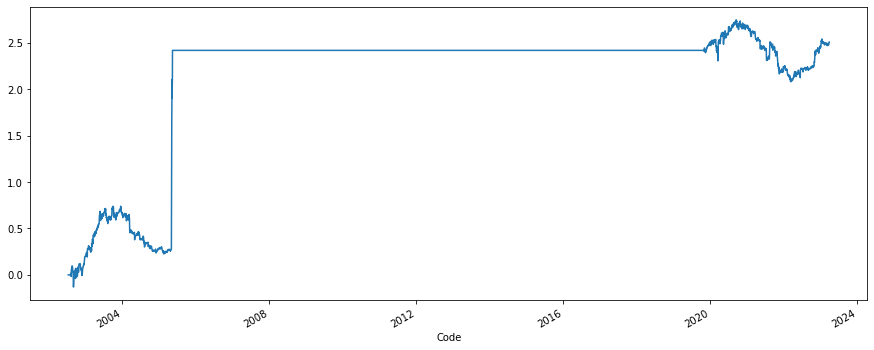

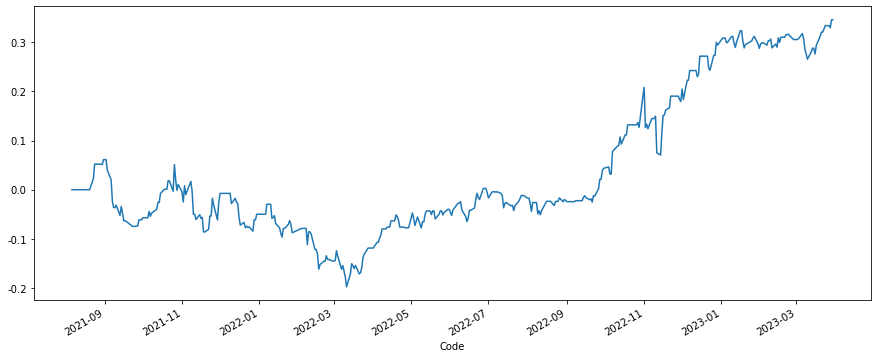

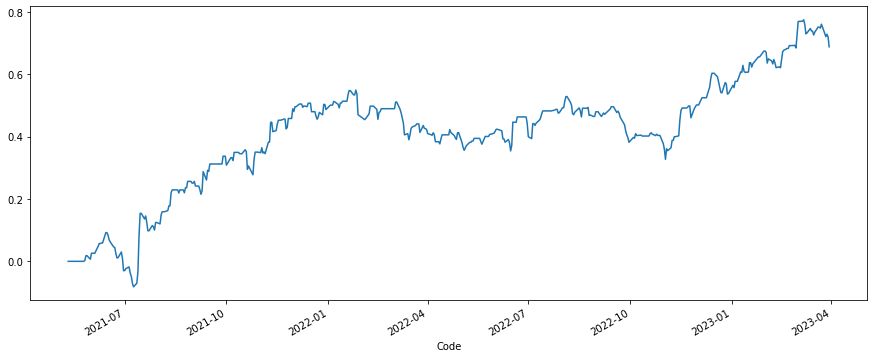

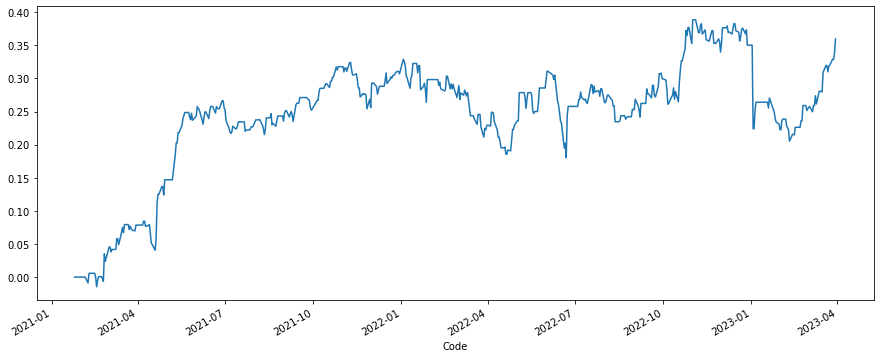

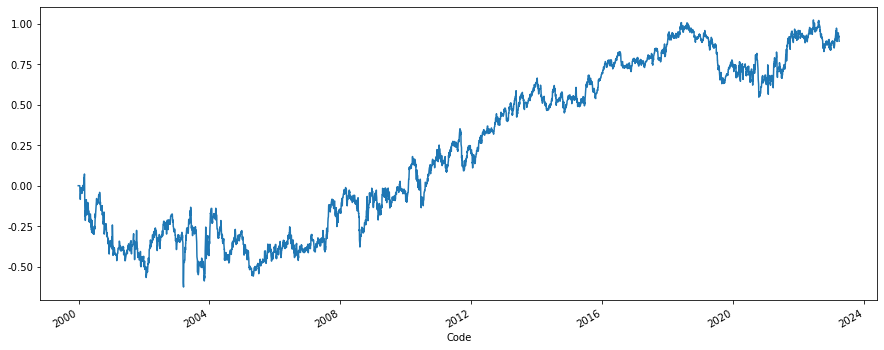

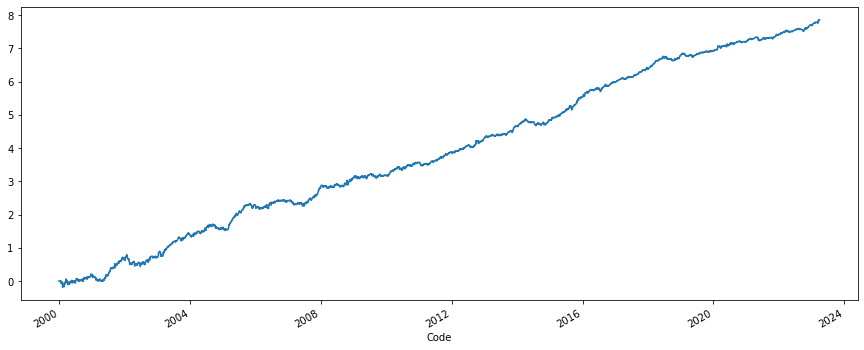

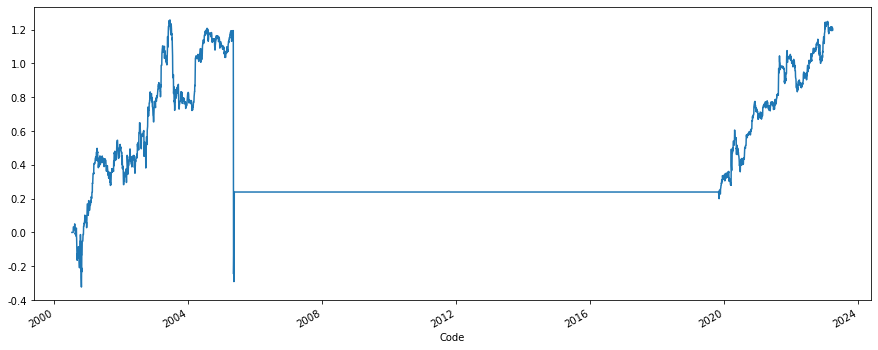

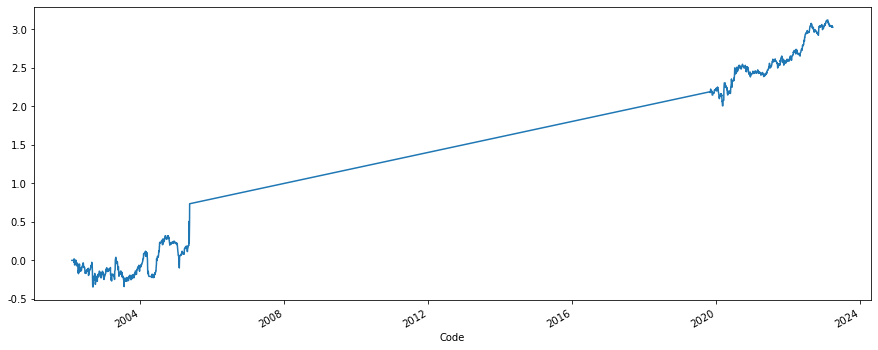

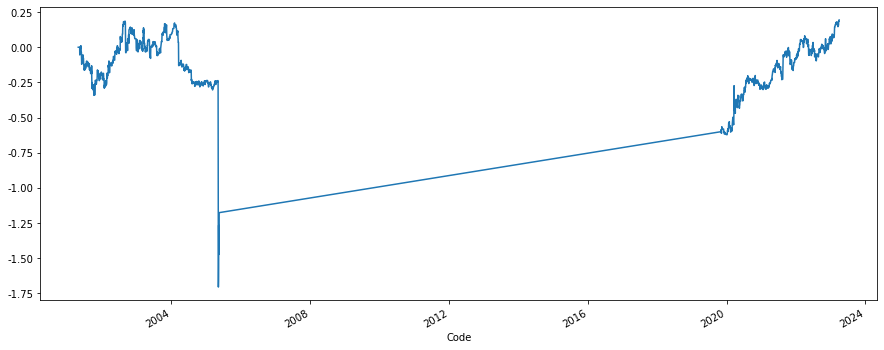

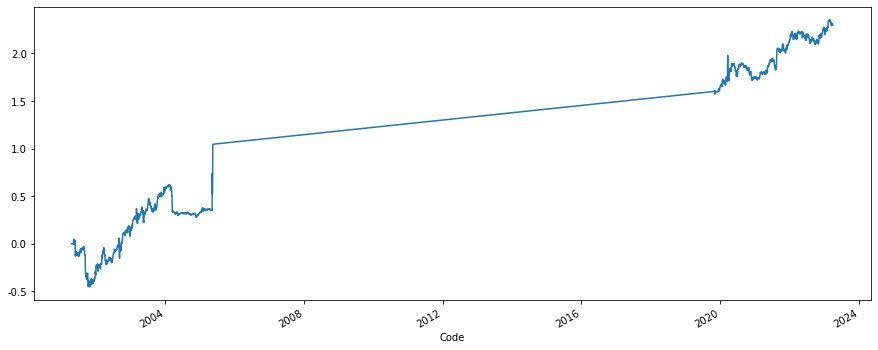

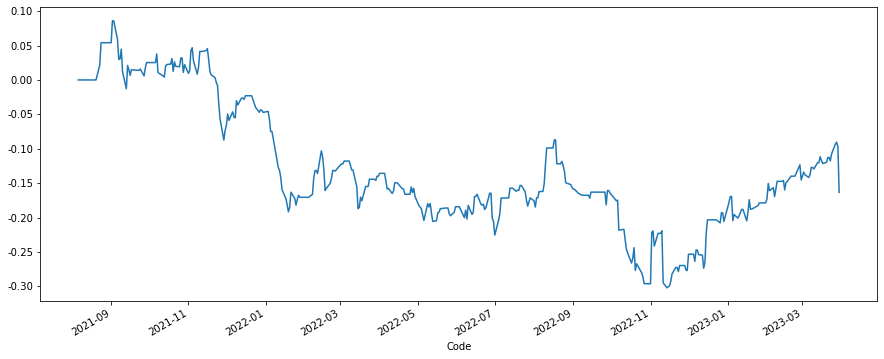

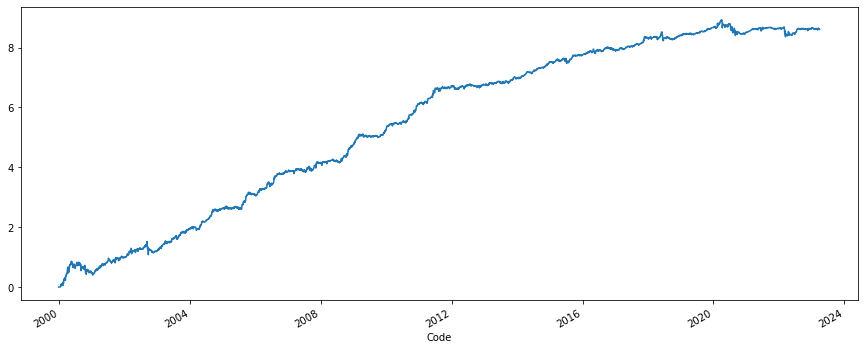

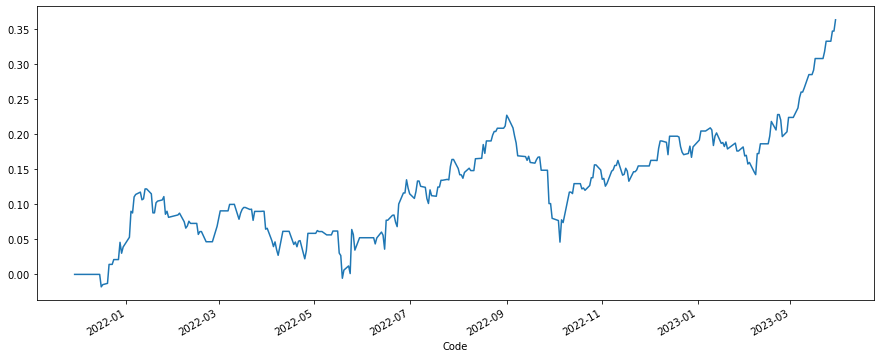

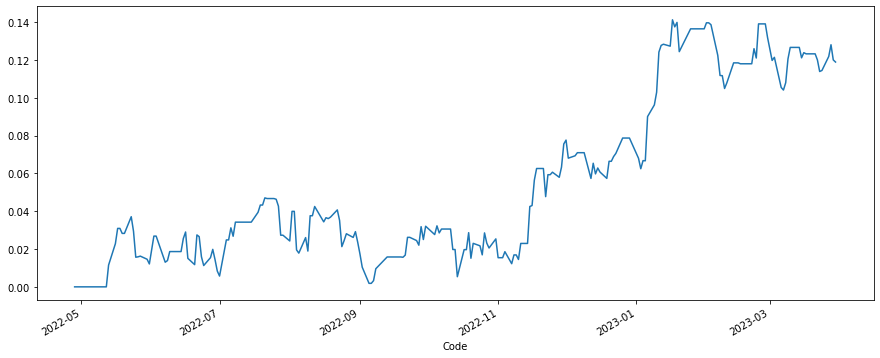

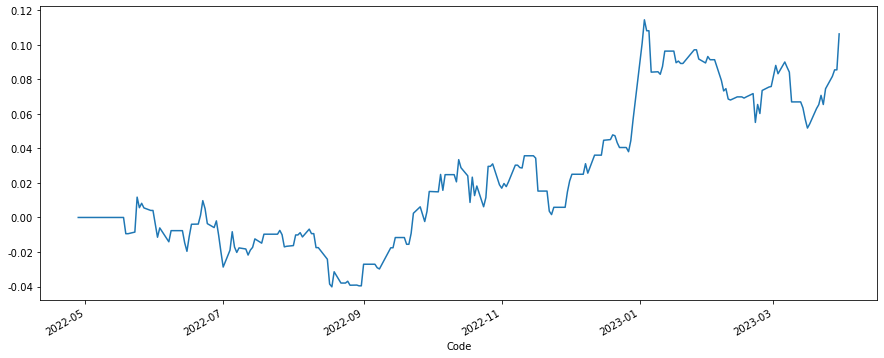

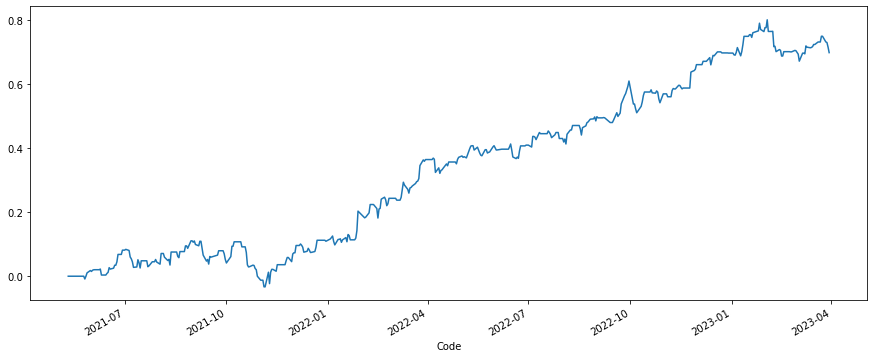

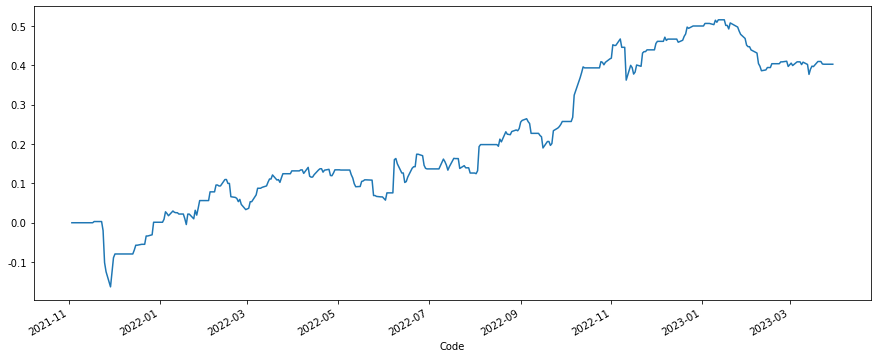

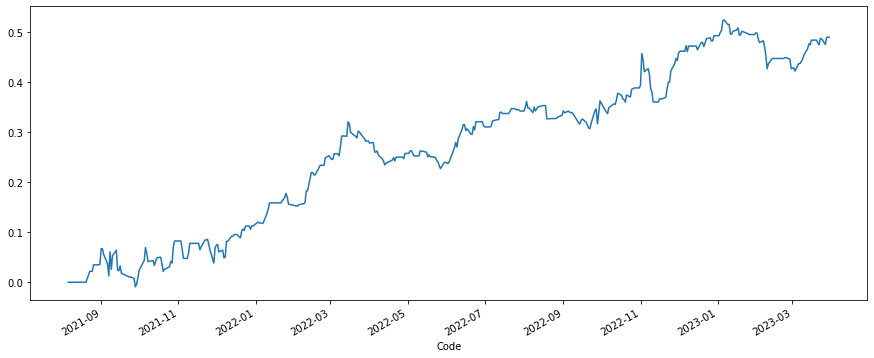

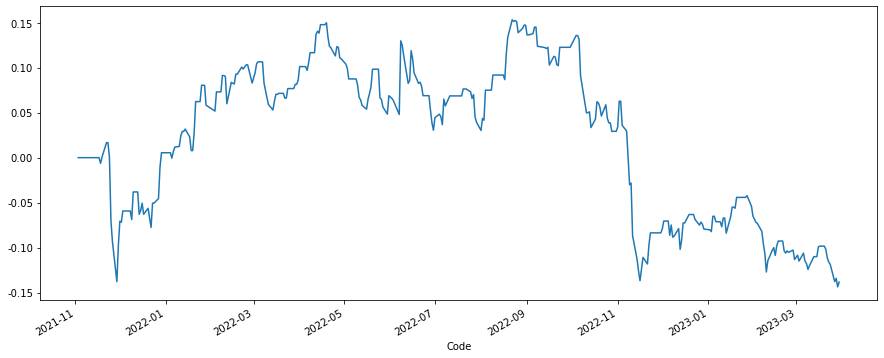

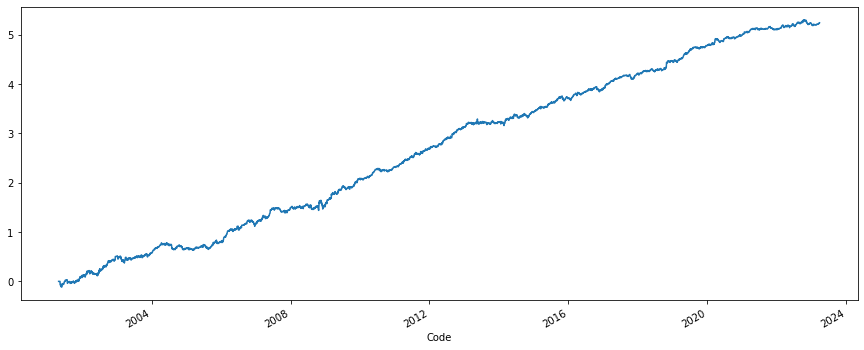

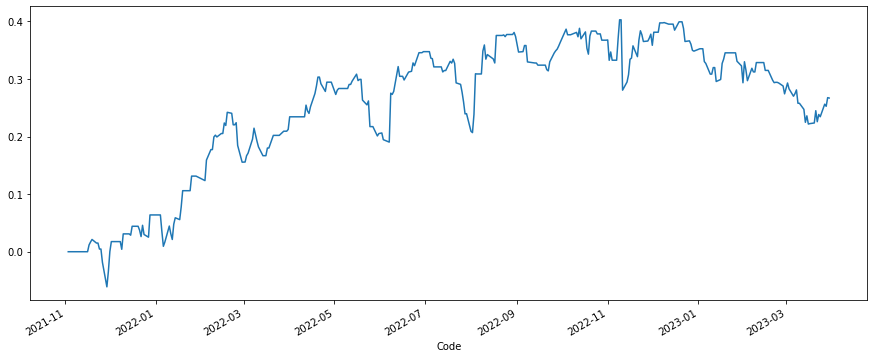

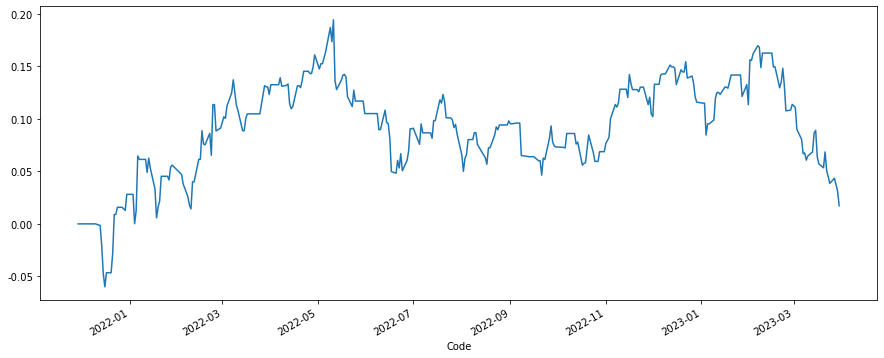

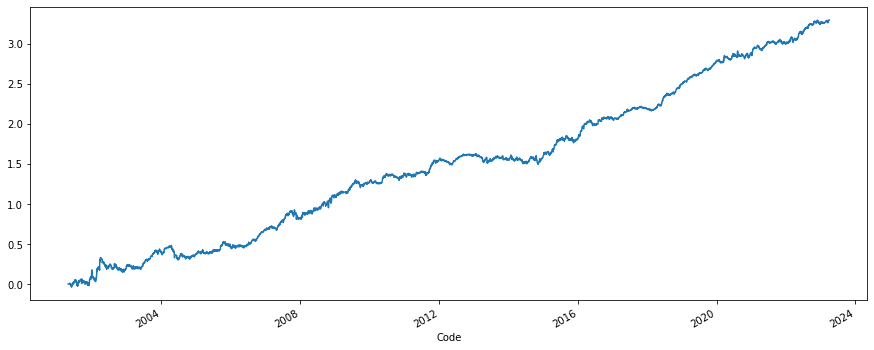

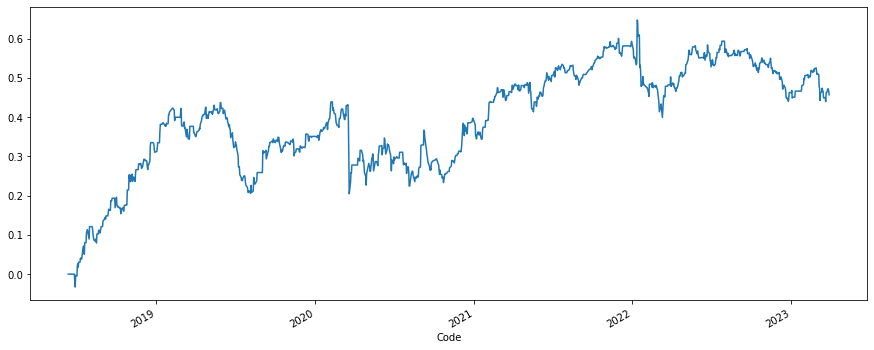

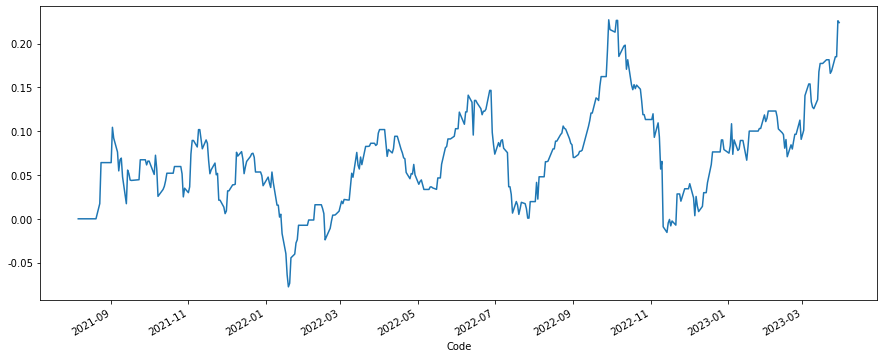

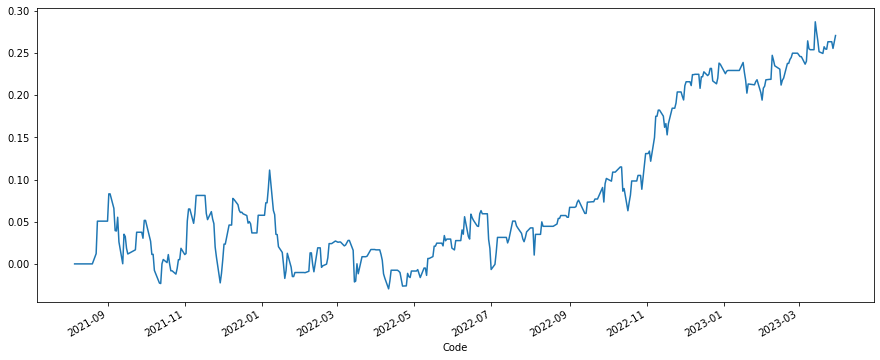

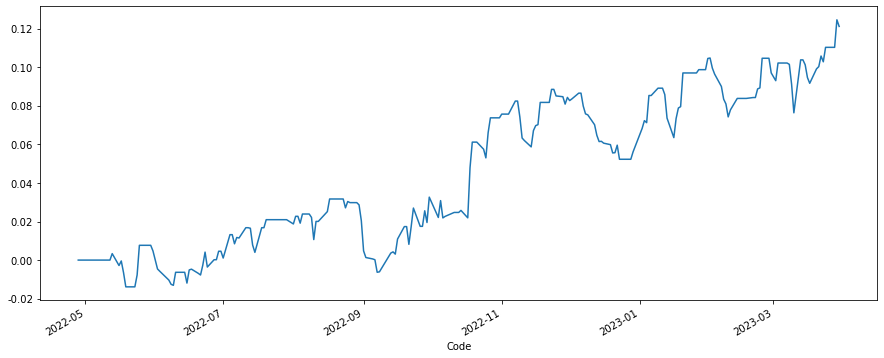

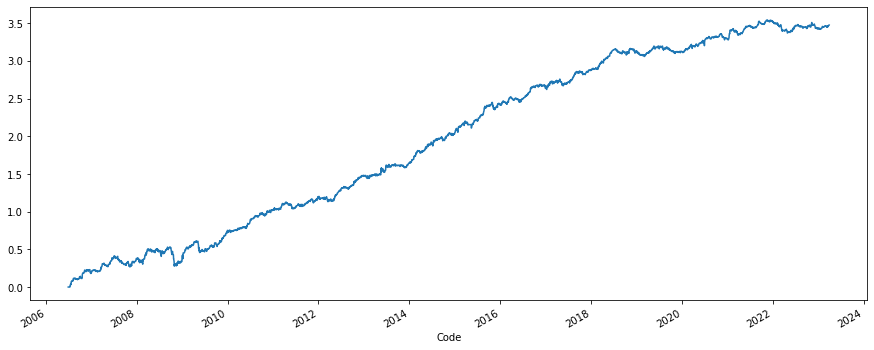

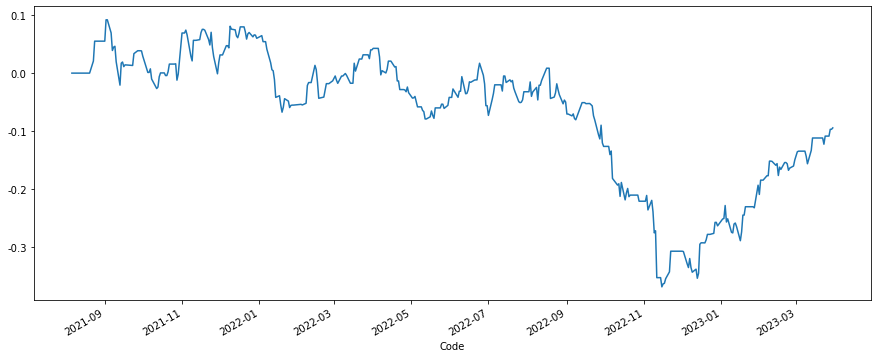

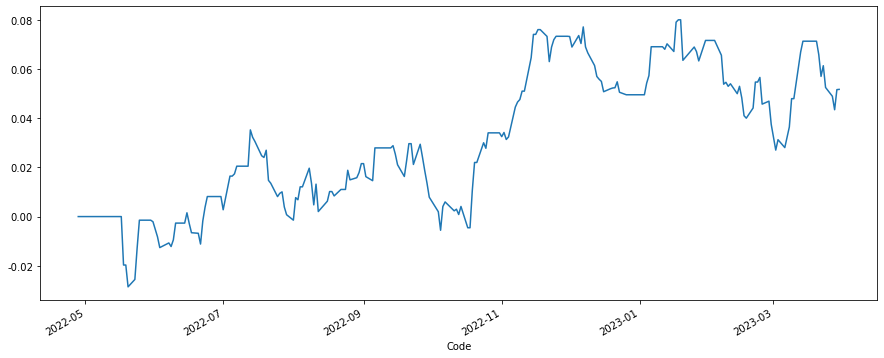

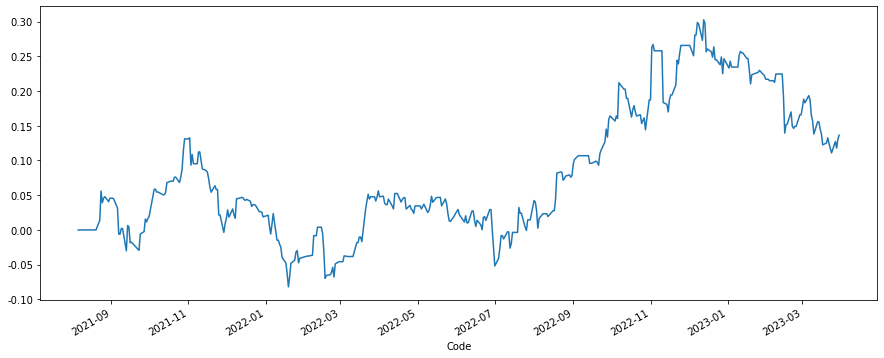

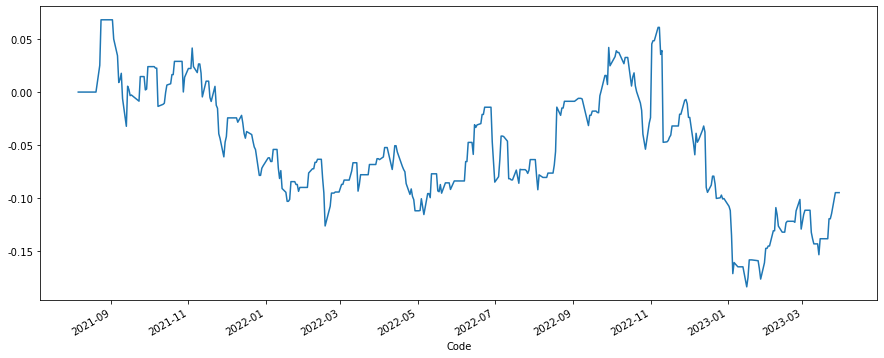

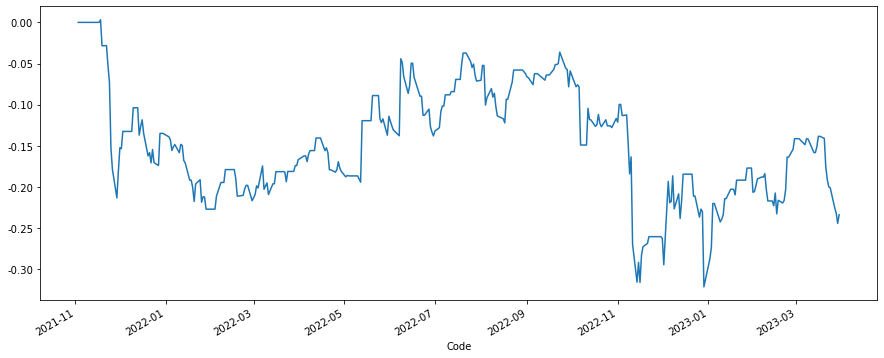

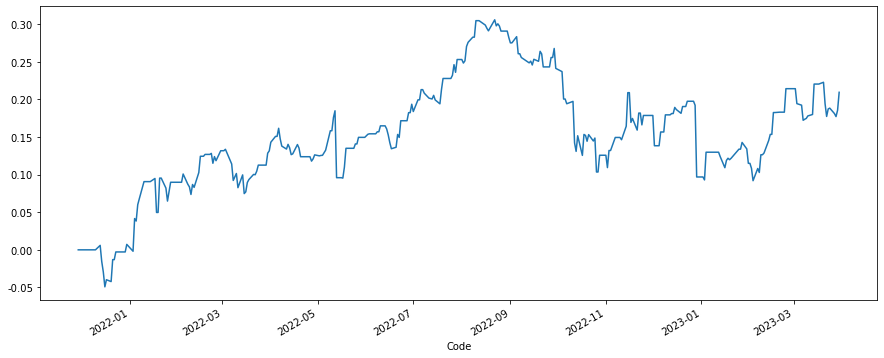

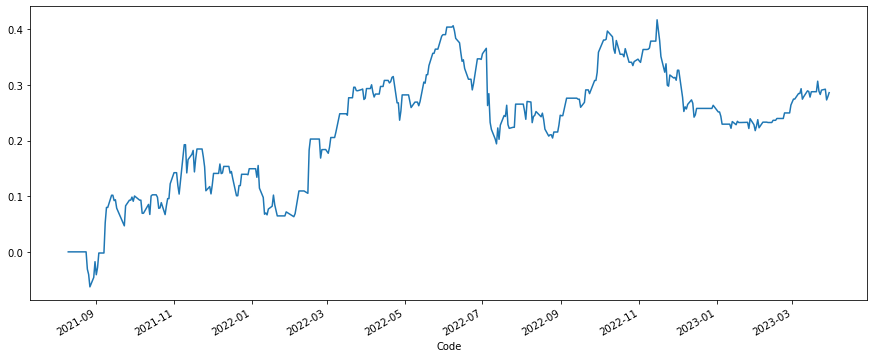

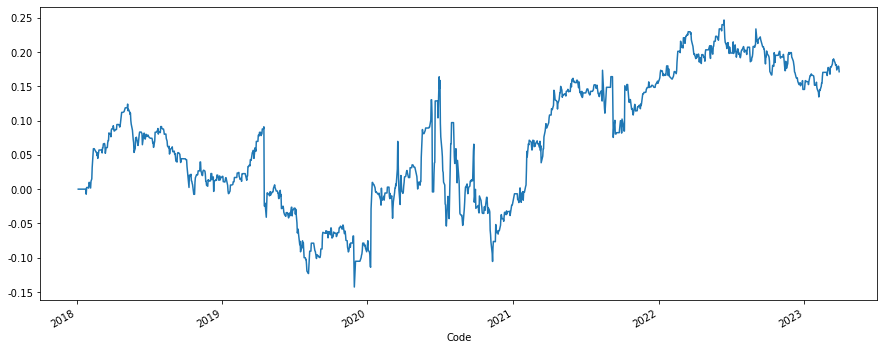

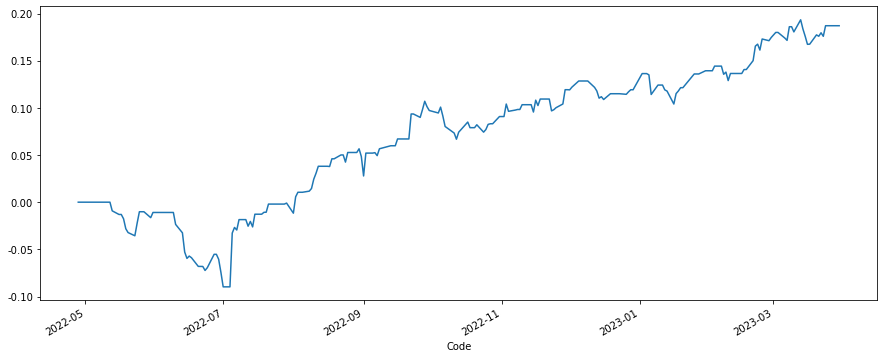

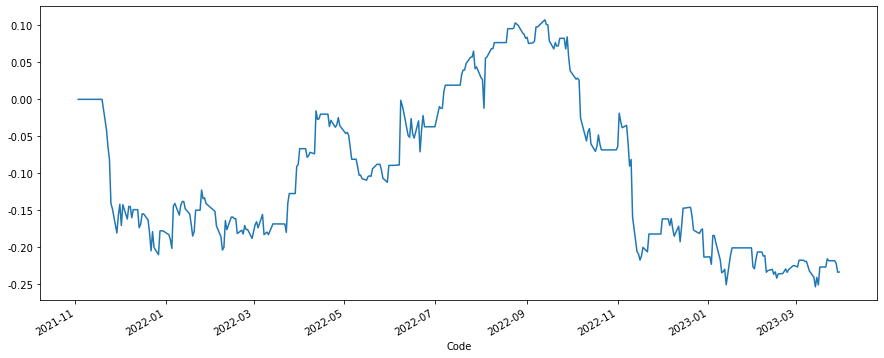

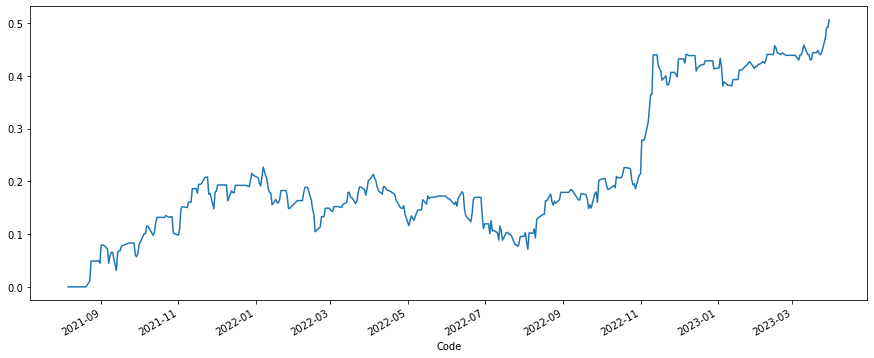

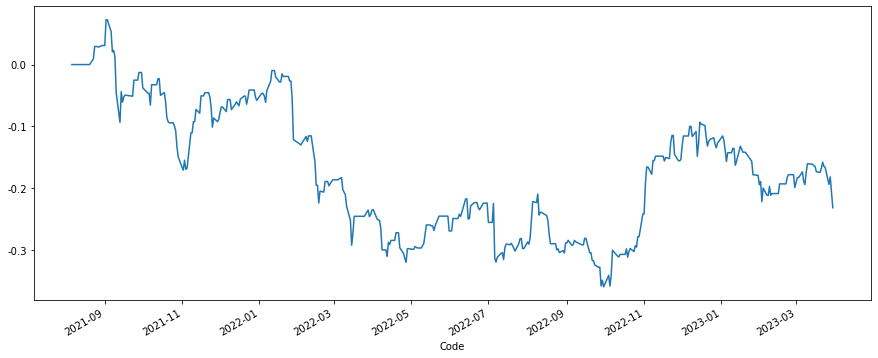

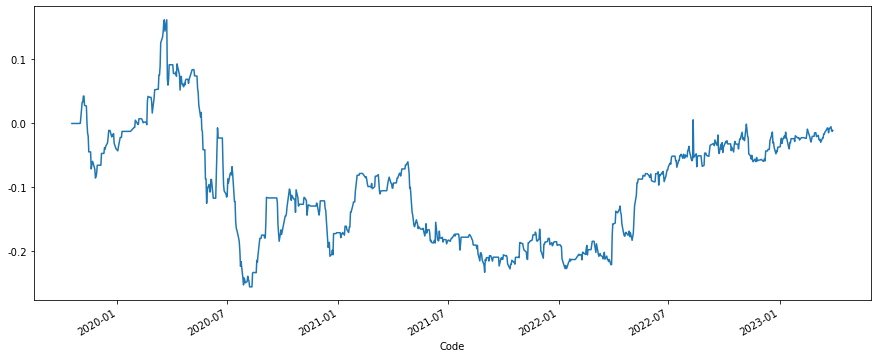

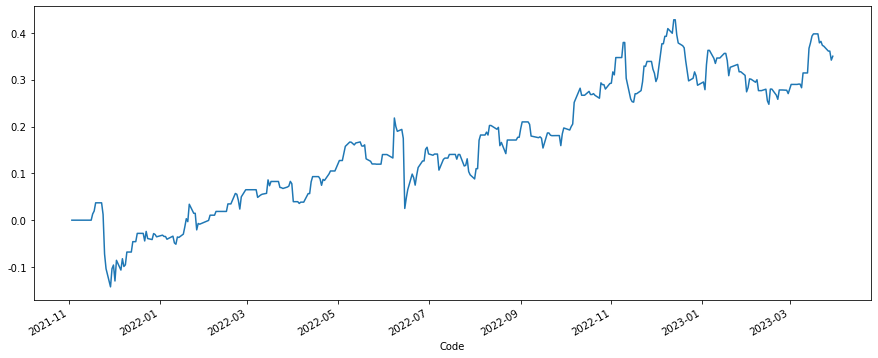

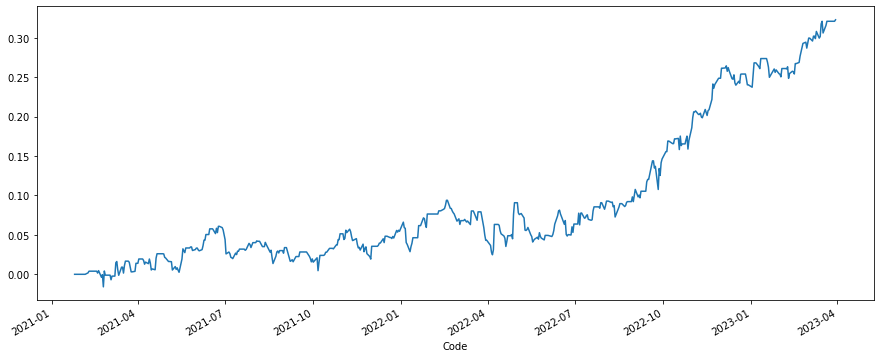

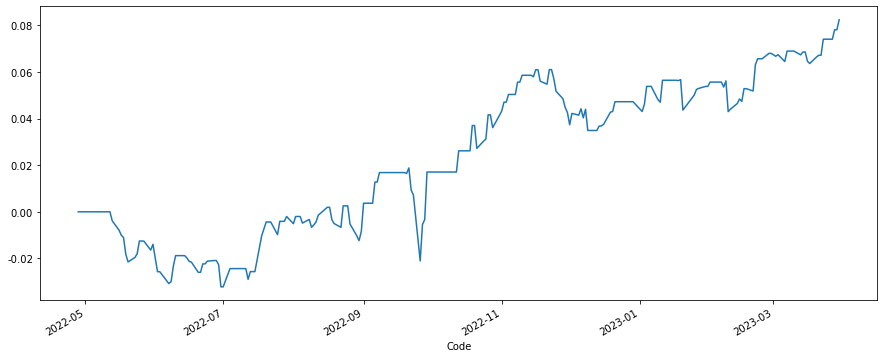

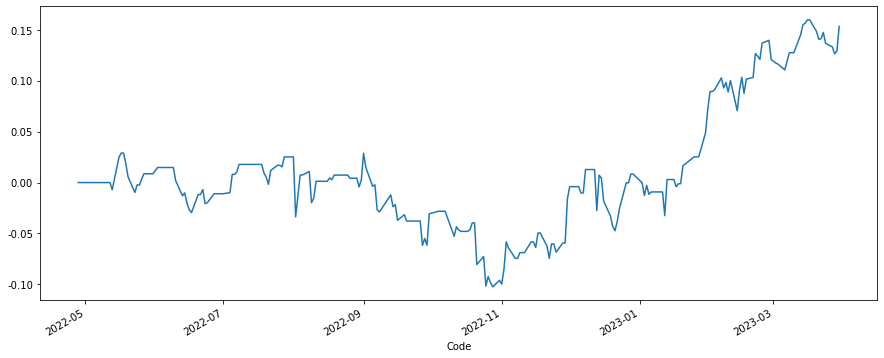

In [10]:
res = []
for i in possible_new_pairs:
    df = df2[i]
    df = df.dropna()
    predicted_diff = kf(df)
    total, _= ls_backtest(df,predicted_diff, 10, 0.5,2.5)
    total.plot(figsize=(15,6))
    plt.show()
    ret, vol, mdd = a.performance(total+1)
    res.append([i, ret, vol, mdd])

In [11]:
res_df = pd.DataFrame(res, columns =["Pair_code", "Ret","Std","Mdd"])
res_df['IR'] = res_df["Ret"]/res_df["Std"]
res_df.mean()

C:\Users\seongsh\AppData\Local\Temp\ipykernel_16424\2579201566.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  res_df.mean()


Ret    0.082896
Std    0.130578
Mdd   -0.265229
IR     1.589723
dtype: float64

In [17]:
temp

377300   402340
Code                         
2021-11-29  238500.0  76000.0
2021-11-30  218000.0  68000.0
2021-12-01  207500.0  62700.0
2021-12-02  208000.0  68700.0
2021-12-03  204500.0  66000.0
...              ...      ...
2023-03-24   57500.0  37500.0
2023-03-27   54700.0  36900.0
2023-03-28   55100.0  37350.0
2023-03-29   53800.0  38050.0
2023-03-30   54100.0  39300.0

[331 rows x 2 columns]

<AxesSubplot:xlabel='Code'>

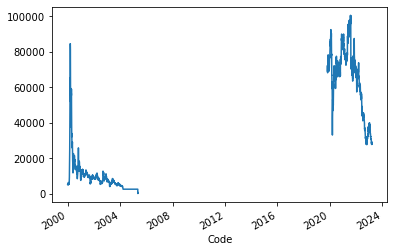

In [32]:
df2["013890"].

<AxesSubplot:xlabel='Code'>

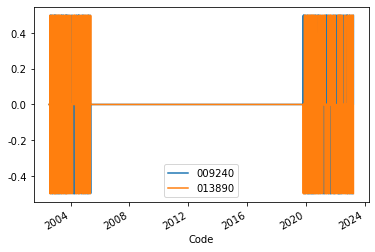

In [24]:
units.plot()

[0.0, 0.0]

In [45]:
[Code_name[j] for j in i]

['현대해상', 'DB손해보험']

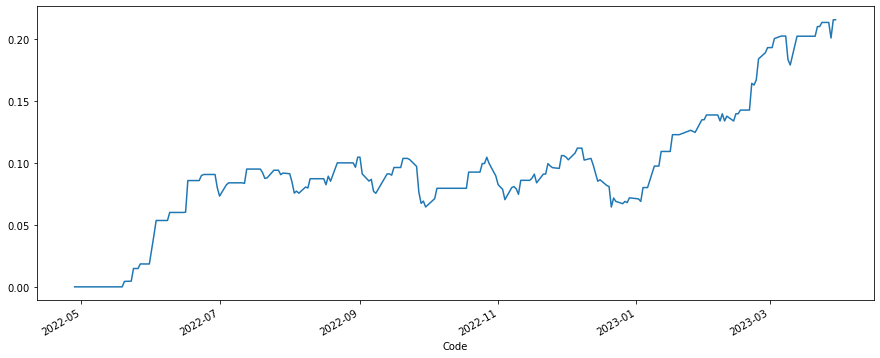

['CJ대한통운', '지누스']

000120   -0.4975
013890    0.4975
Name: 2023-03-30 00:00:00, dtype: float64

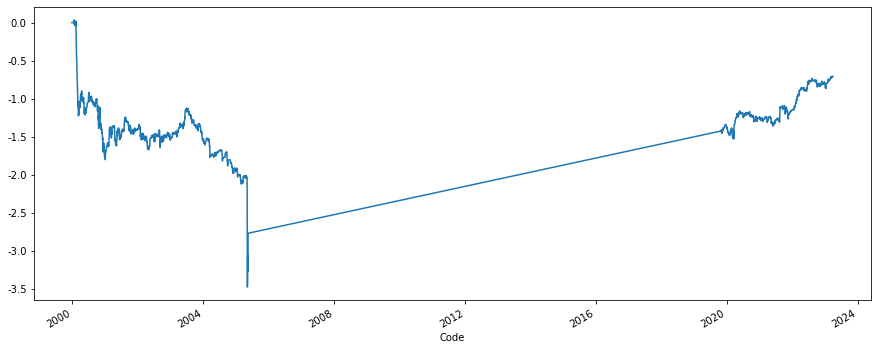

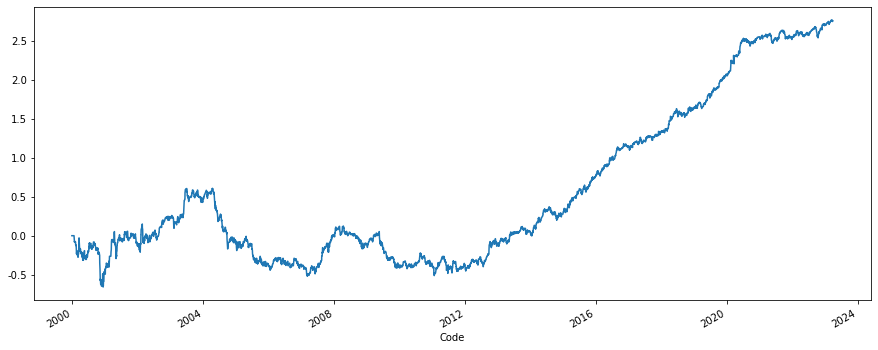

['하이트진로홀딩스', '하이트진로홀딩스우']

000140   -0.4975
000145    0.4975
Name: 2023-03-30 00:00:00, dtype: float64

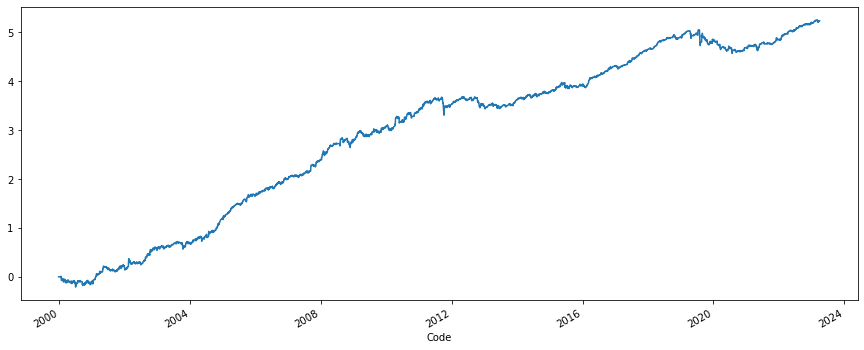

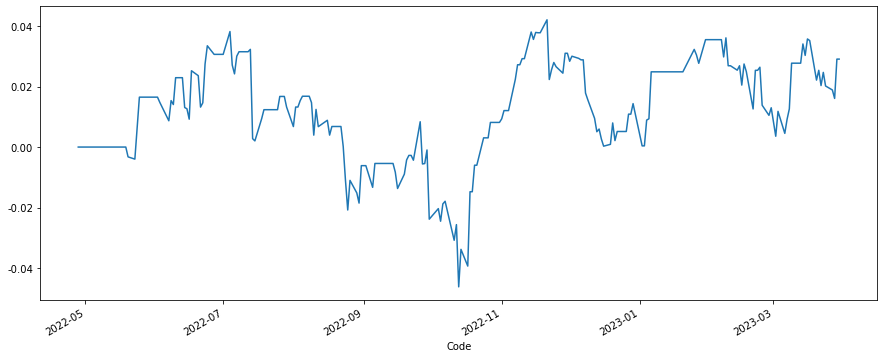

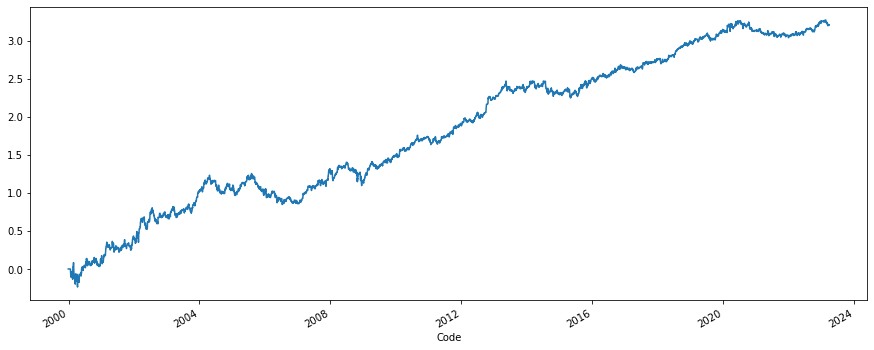

['한화', '한화3우B']

000880   -0.4975
00088K    0.4975
Name: 2023-03-30 00:00:00, dtype: float64

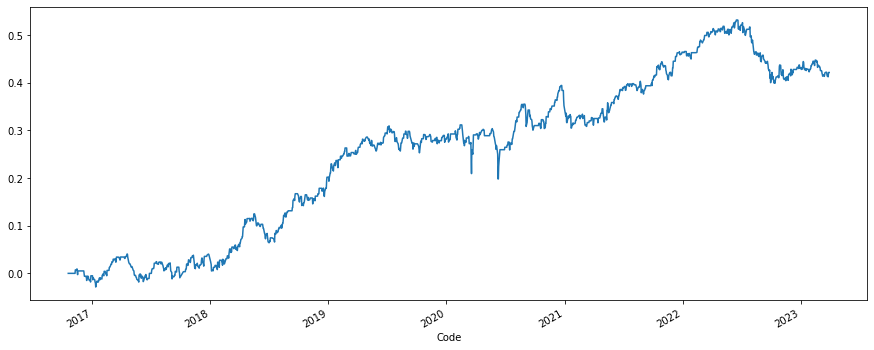

['현대해상', 'DB손해보험']

001450    0.4975
005830   -0.4975
Name: 2023-03-30 00:00:00, dtype: float64

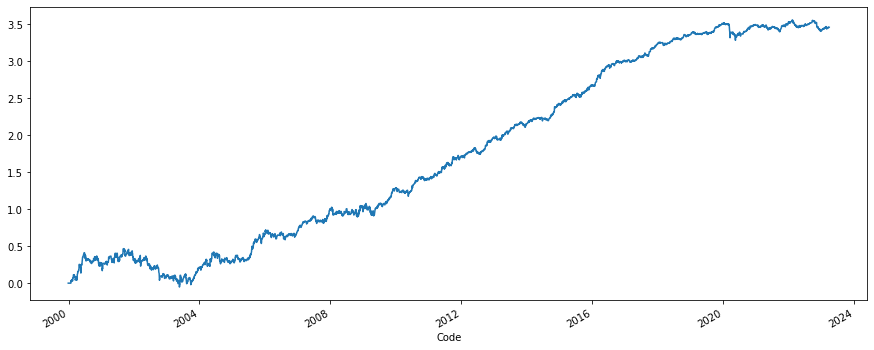

['현대차증권', '크래프톤']

001500    0.4975
259960   -0.4975
Name: 2023-03-30 00:00:00, dtype: float64

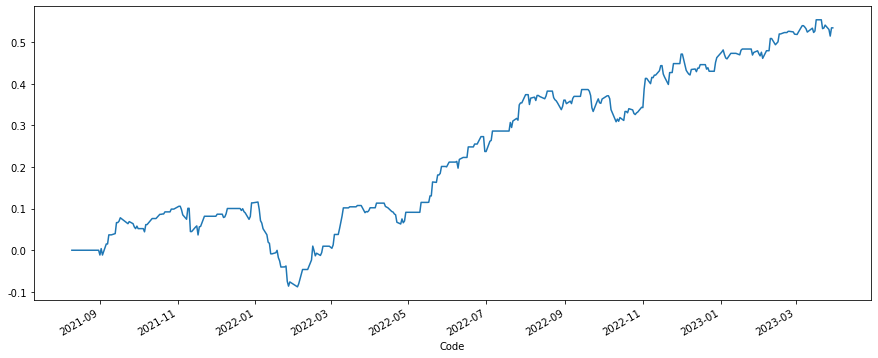

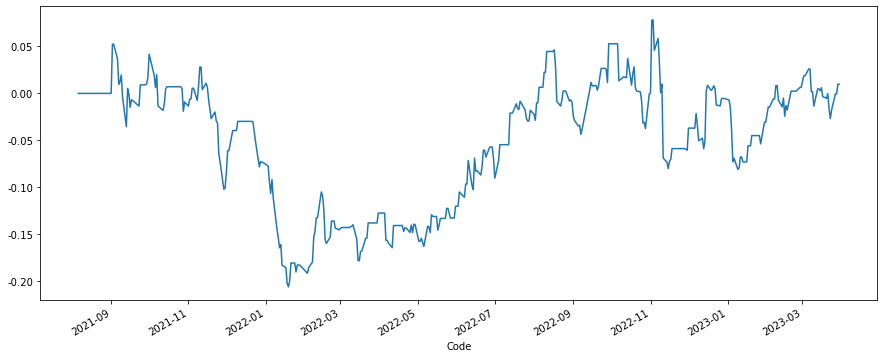

['대상우', '호텔신라우']

001685    0.4975
008775   -0.4975
Name: 2023-03-30 00:00:00, dtype: float64

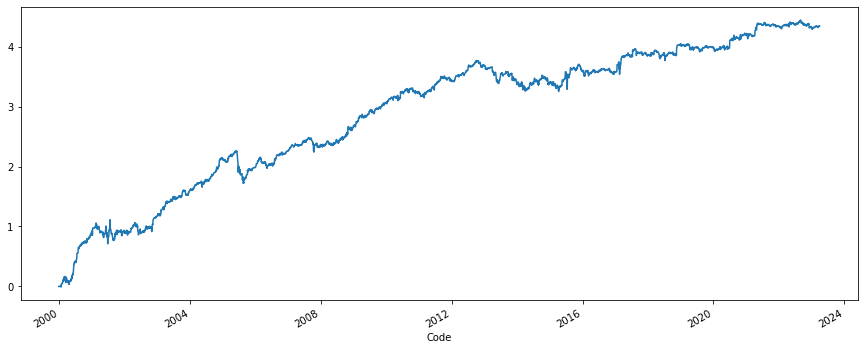

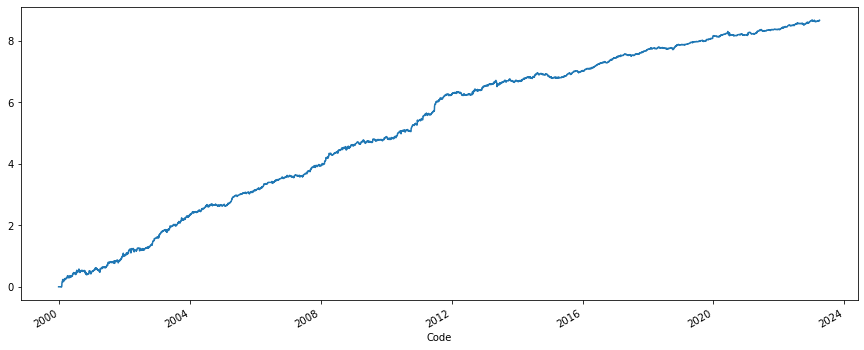

['아모레G', '아모레G3우(전환)']

002790   -0.4975
00279K    0.4975
Name: 2023-03-30 00:00:00, dtype: float64

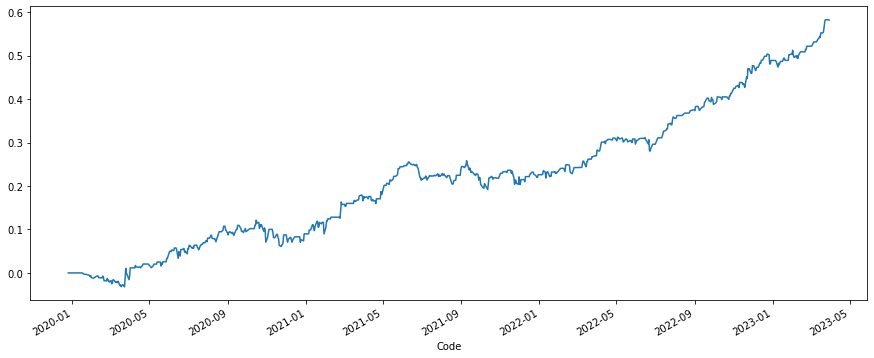

['아모레G', '아모레퍼시픽']

002790    0.4975
090430   -0.4975
Name: 2023-03-30 00:00:00, dtype: float64

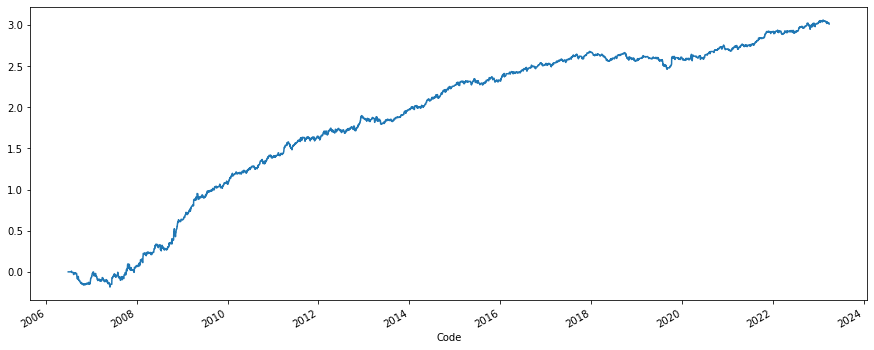

['아모레G', '아모레퍼시픽우']

002790    0.4975
090435   -0.4975
Name: 2023-03-30 00:00:00, dtype: float64

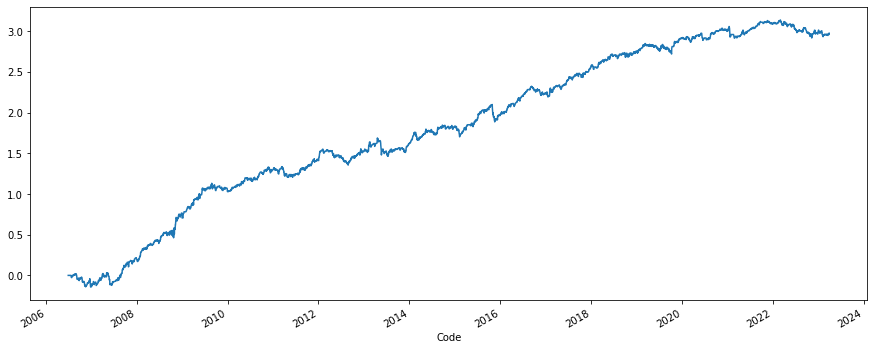

['아모레G우', '아모레퍼시픽']

002795    0.4975
090430   -0.4975
Name: 2023-03-30 00:00:00, dtype: float64

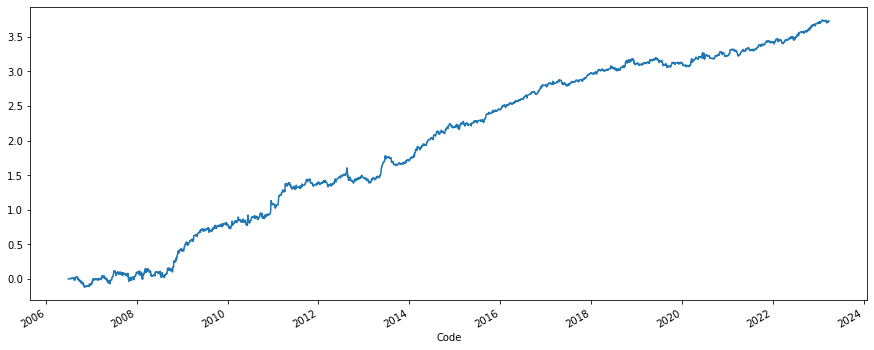

['아모레G우', '아모레퍼시픽우']

002795    0.4975
090435   -0.4975
Name: 2023-03-30 00:00:00, dtype: float64

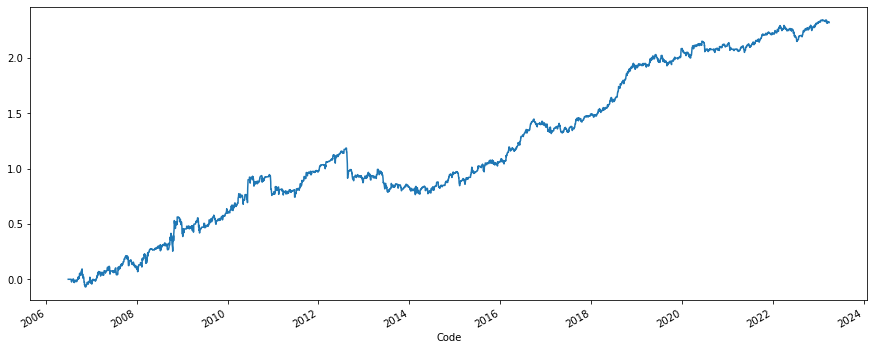

['대한항공우', '씨에스윈드']

003495    0.4975
112610   -0.4975
Name: 2023-03-30 00:00:00, dtype: float64

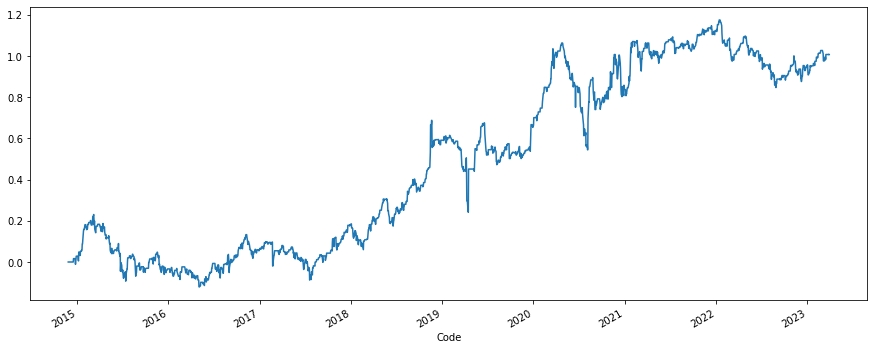

['한화투자증권', 'SK스퀘어']

003530    0.4975
402340   -0.4975
Name: 2023-03-30 00:00:00, dtype: float64

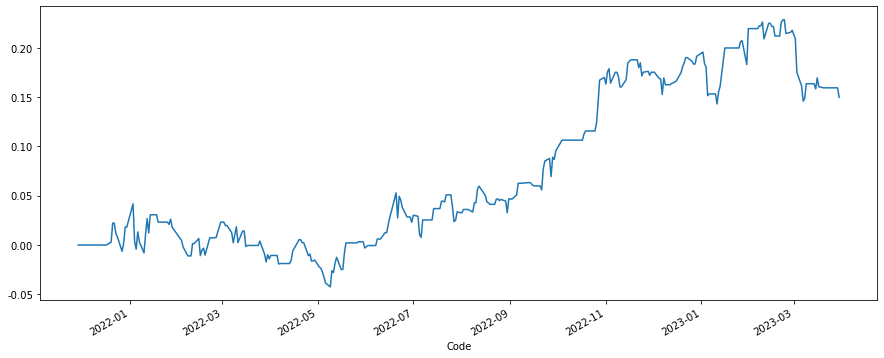

['한화투자증권우', 'SK스퀘어']

003535    0.4975
402340   -0.4975
Name: 2023-03-30 00:00:00, dtype: float64

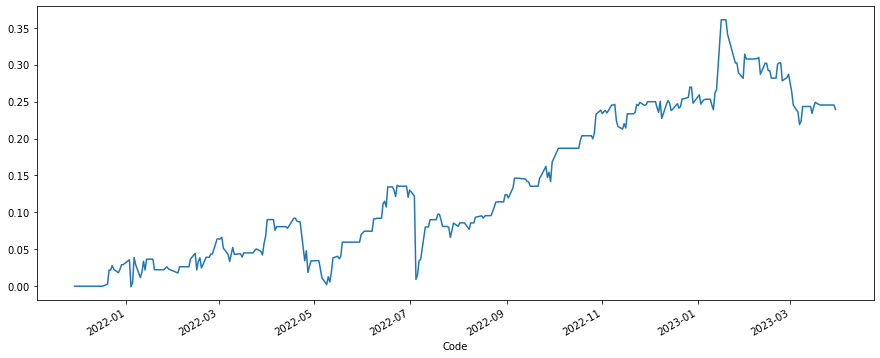

['포스코케미칼', '삼성SDI']

003670   -0.4975
006400    0.4975
Name: 2023-03-30 00:00:00, dtype: float64

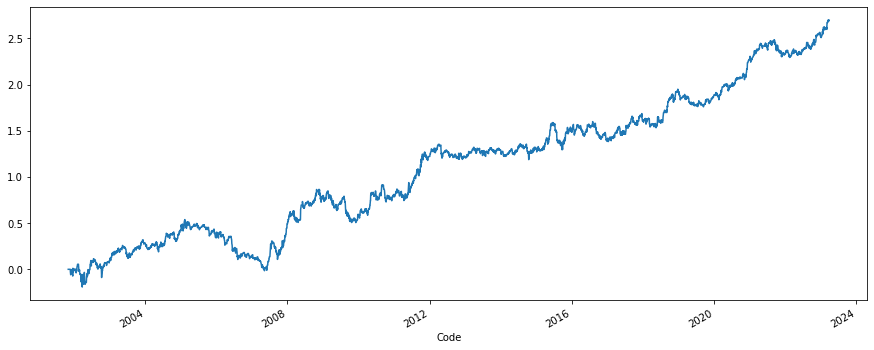

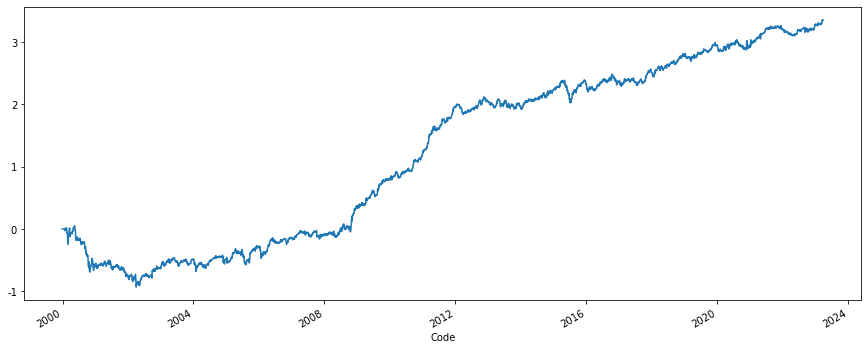

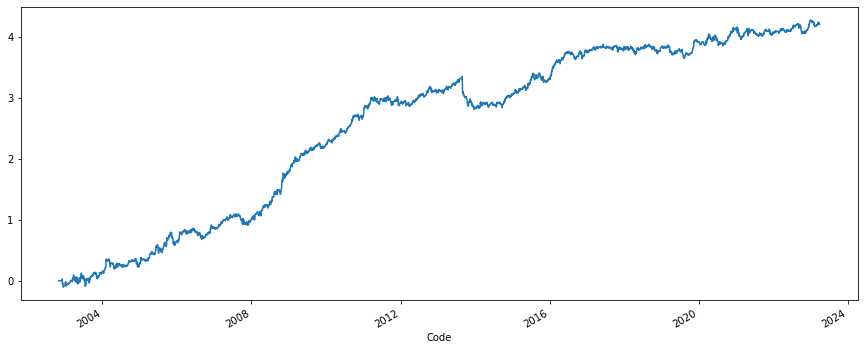

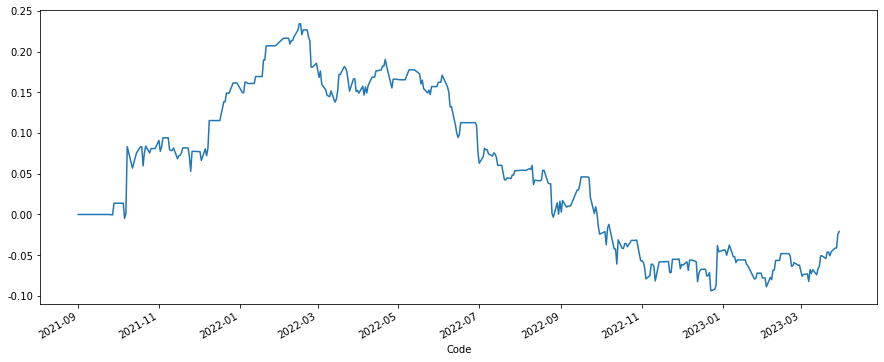

['효성', 'SK아이이테크놀로지']

004800    0.4975
361610   -0.4975
Name: 2023-03-30 00:00:00, dtype: float64

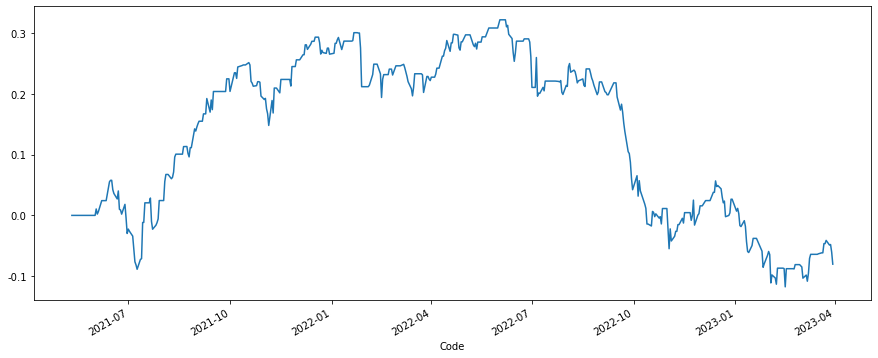

['녹십자홀딩스', '카카오뱅크']

005250   -0.4975
323410    0.4975
Name: 2023-03-30 00:00:00, dtype: float64

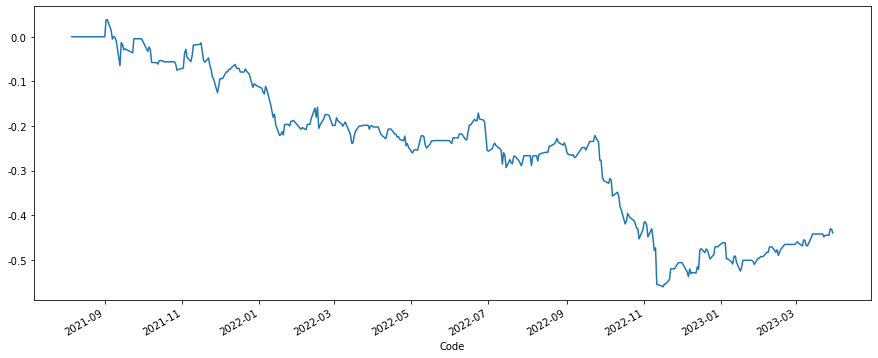

['현대차', '현대모비스']

005380   -0.4975
012330    0.4975
Name: 2023-03-30 00:00:00, dtype: float64

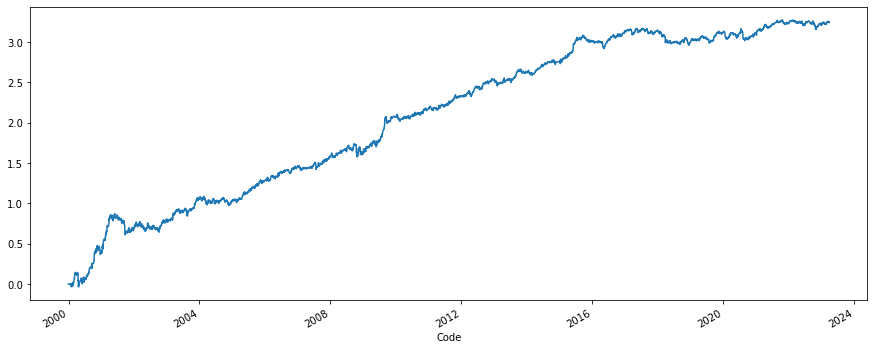

['현대차우', '현대차2우B']

005385    0.4975
005387   -0.4975
Name: 2023-03-30 00:00:00, dtype: float64

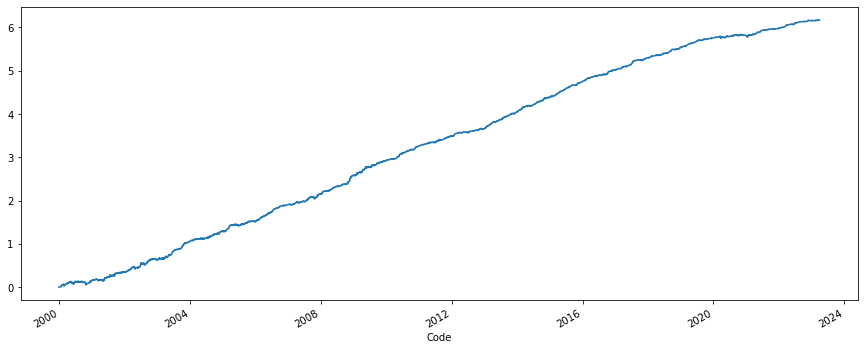

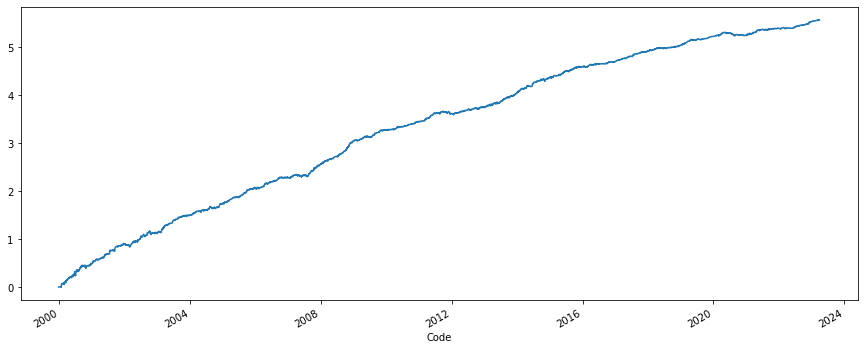

['현대차2우B', '현대차3우B']

005387   -0.4975
005389    0.4975
Name: 2023-03-30 00:00:00, dtype: float64

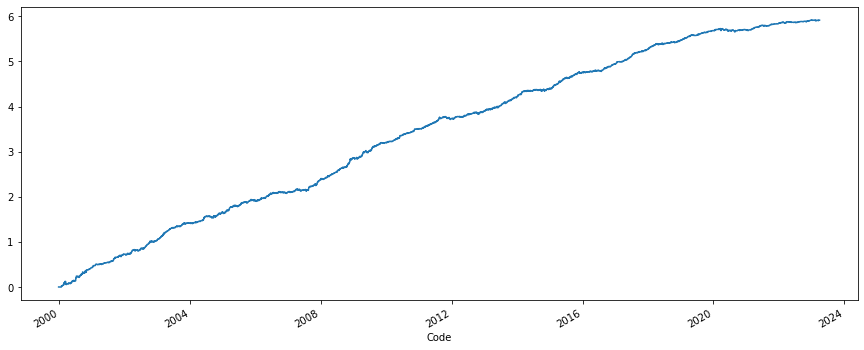

['삼성전자', '삼성전자우']

005930   -0.4975
005935    0.4975
Name: 2023-03-30 00:00:00, dtype: float64

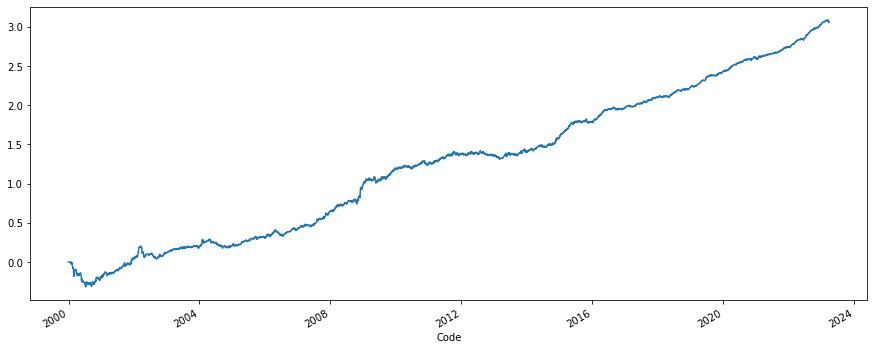

['SK디스커버리우', '일진하이솔루스']

006125    0.4975
271940   -0.4975
Name: 2023-03-30 00:00:00, dtype: float64

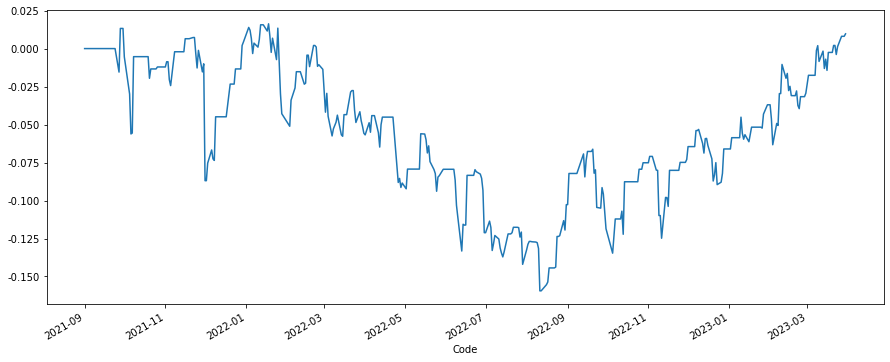

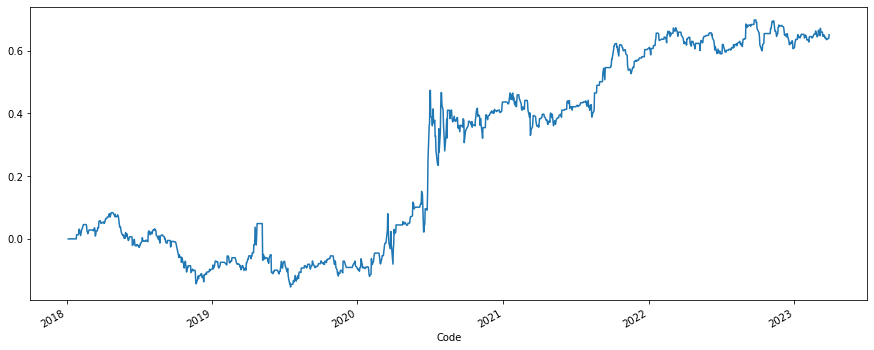

['SK디스커버리우', 'SK케미칼우']

006125    0.4975
28513K   -0.4975
Name: 2023-03-30 00:00:00, dtype: float64

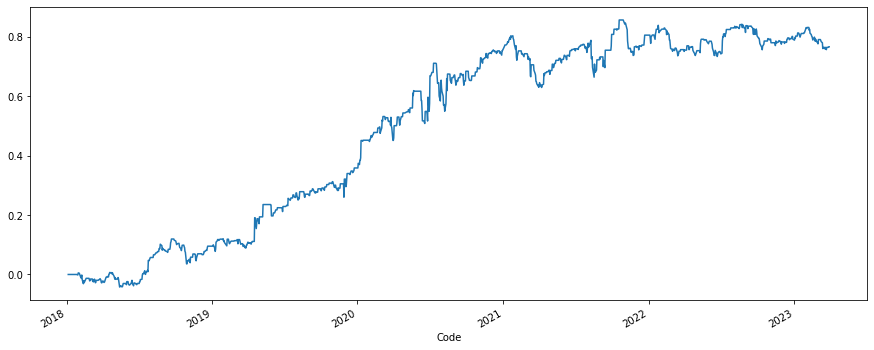

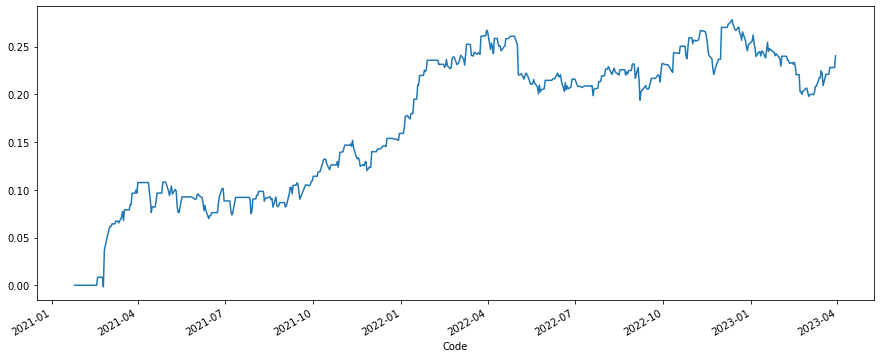

['GS건설', 'DL이앤씨우']

006360   -0.4975
37550K    0.4975
Name: 2023-03-30 00:00:00, dtype: float64

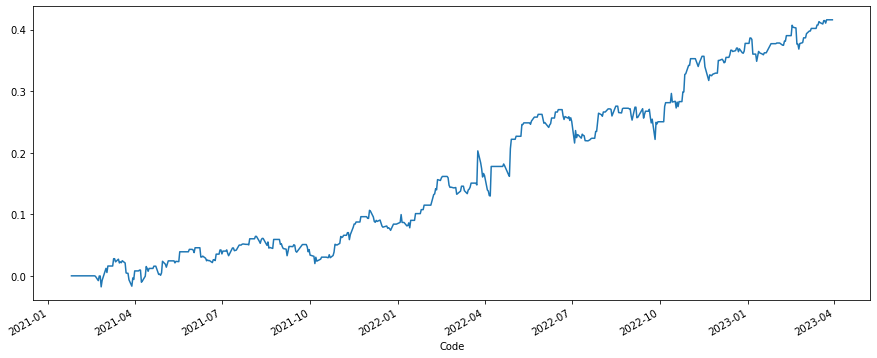

['삼성SDI', '삼성SDI우']

006400    0.4975
006405   -0.4975
Name: 2023-03-30 00:00:00, dtype: float64

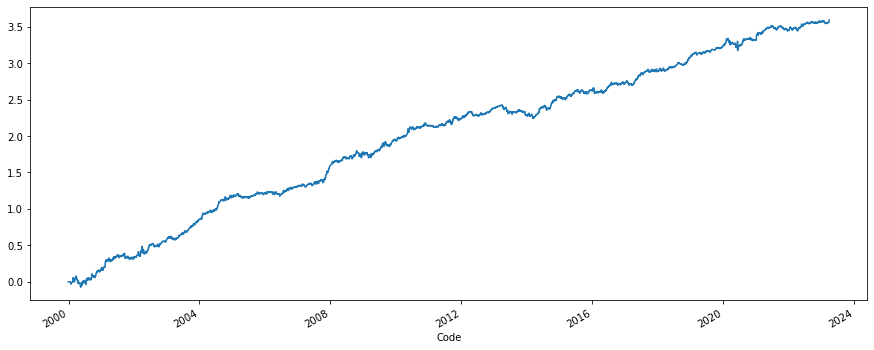

['삼성SDI', '씨에스윈드']

006400    0.4975
112610   -0.4975
Name: 2023-03-30 00:00:00, dtype: float64

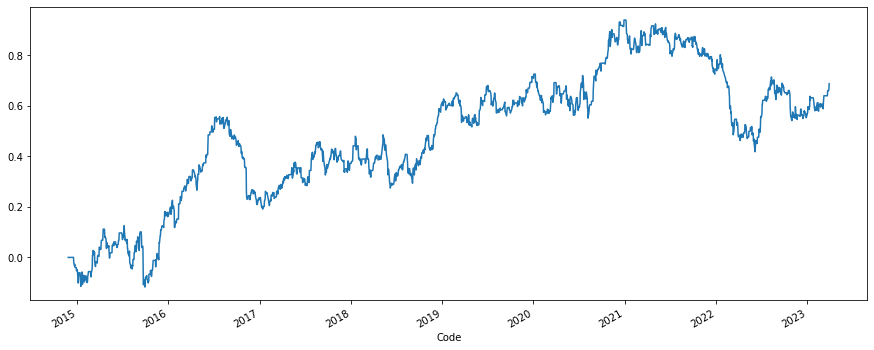

['삼성SDI우', '씨에스윈드']

006405   -0.4975
112610    0.4975
Name: 2023-03-30 00:00:00, dtype: float64

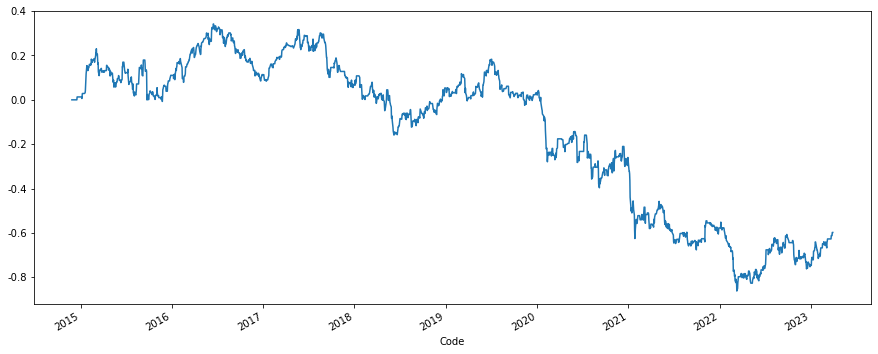

['미래에셋증권2우B', 'SK스퀘어']

00680K    0.4975
402340   -0.4975
Name: 2023-03-30 00:00:00, dtype: float64

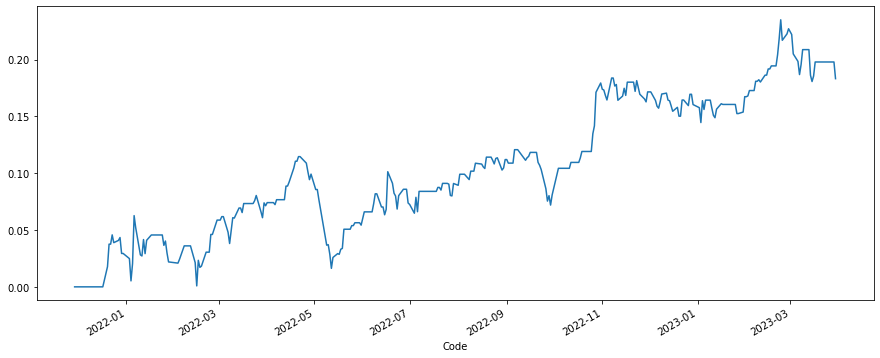

['한샘', '지누스']

009240    0.4975
013890   -0.4975
Name: 2023-03-30 00:00:00, dtype: float64

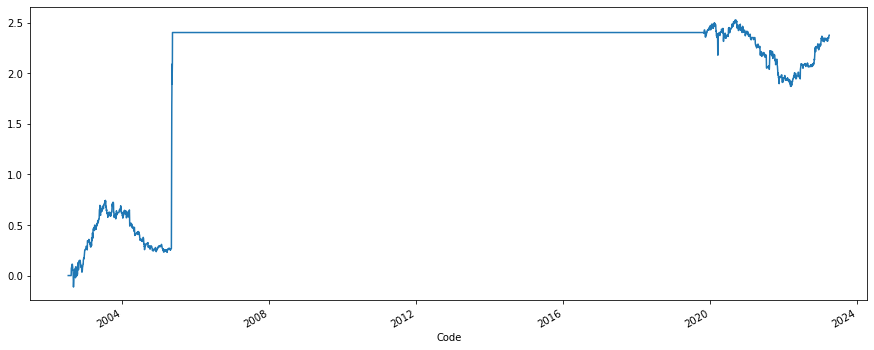

['한샘', '카카오뱅크']

009240    0.4975
323410   -0.4975
Name: 2023-03-30 00:00:00, dtype: float64

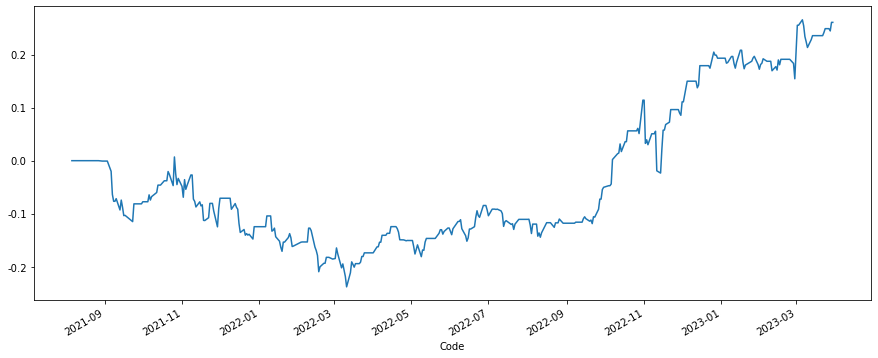

['한샘', 'SK아이이테크놀로지']

009240    0.4975
361610   -0.4975
Name: 2023-03-30 00:00:00, dtype: float64

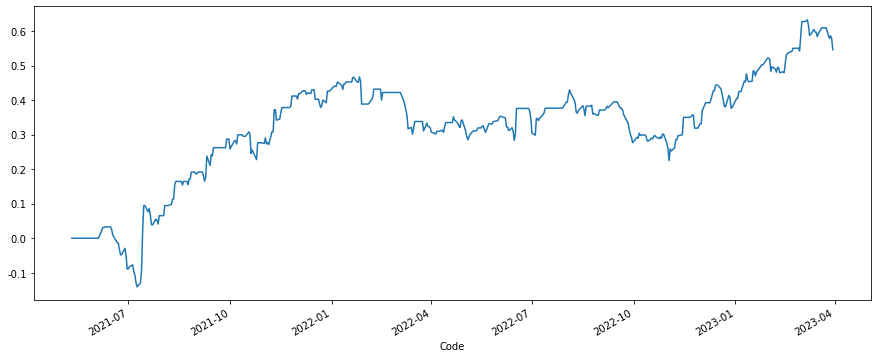

['CJ씨푸드1우', 'DL이앤씨']

011155    0.4975
375500   -0.4975
Name: 2023-03-30 00:00:00, dtype: float64

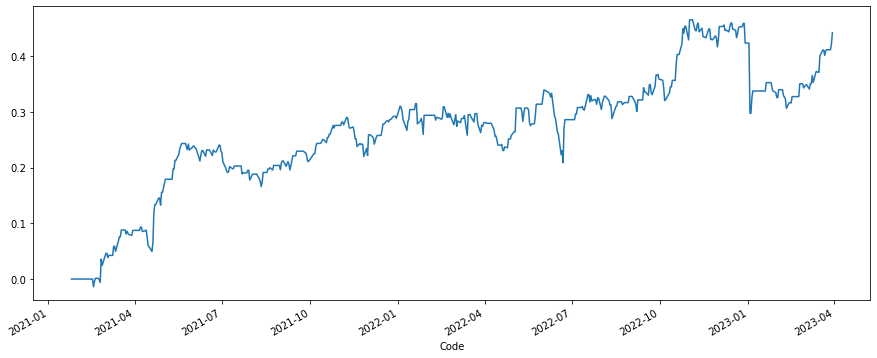

['금호석유우', 'SKC']

011785    0.4975
011790   -0.4975
Name: 2023-03-30 00:00:00, dtype: float64

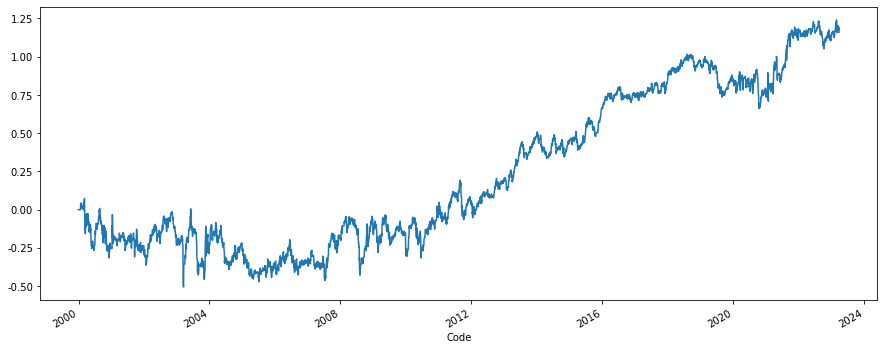

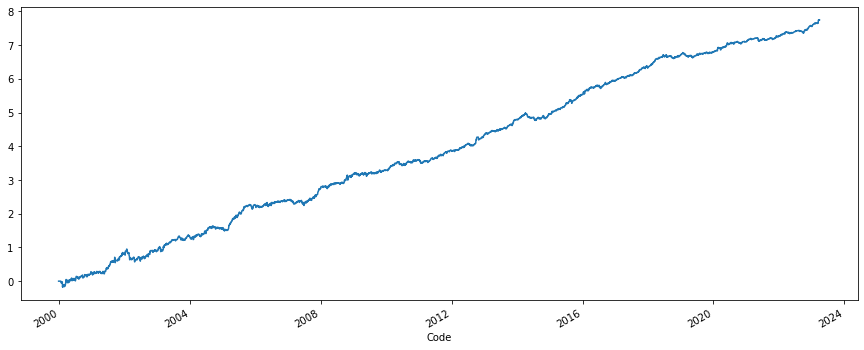

['지누스', '엔씨소프트']

013890   -0.4975
036570    0.4975
Name: 2023-03-30 00:00:00, dtype: float64

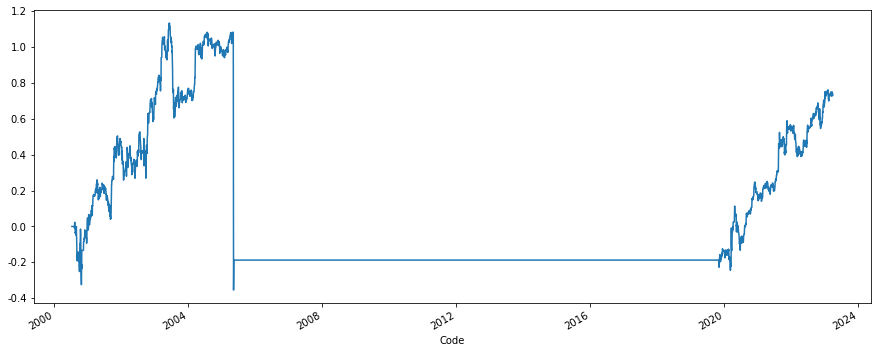

['지누스', '코스맥스비티아이']

013890    0.4975
044820   -0.4975
Name: 2023-03-30 00:00:00, dtype: float64

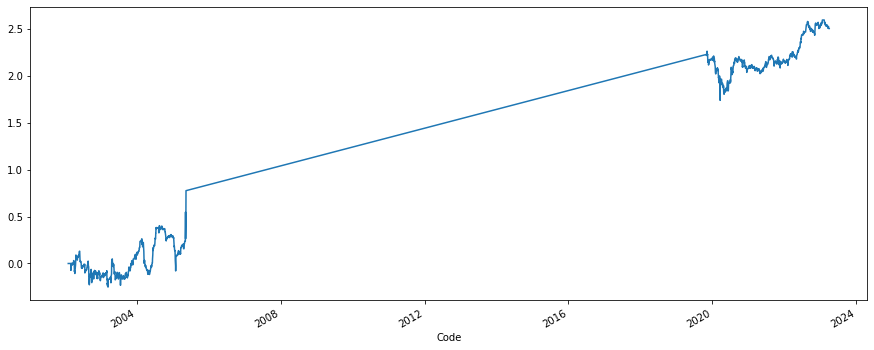

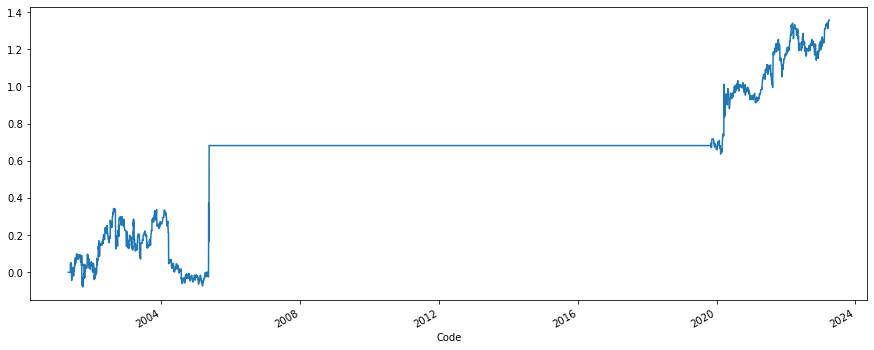

['지누스', 'LG생활건강우']

013890   -0.4975
051905    0.4975
Name: 2023-03-30 00:00:00, dtype: float64

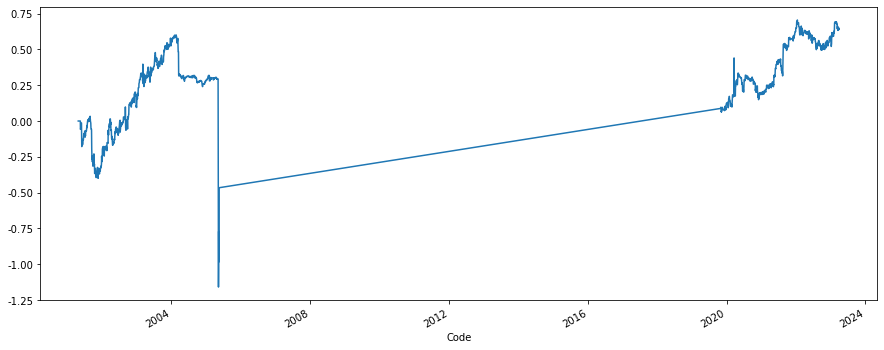

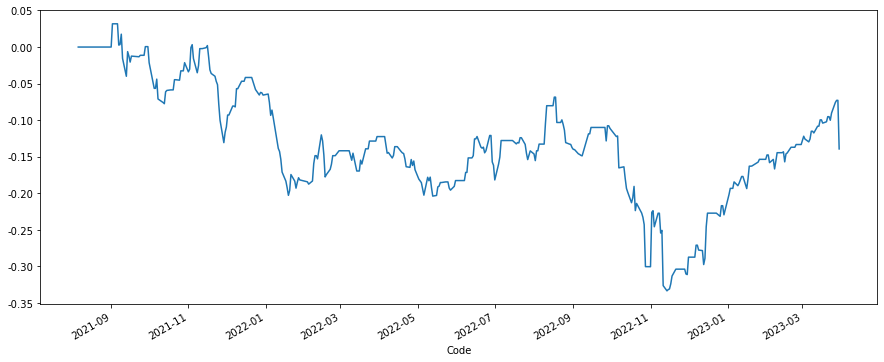

['신풍제약', '신풍제약우']

019170   -0.4975
019175    0.4975
Name: 2023-03-30 00:00:00, dtype: float64

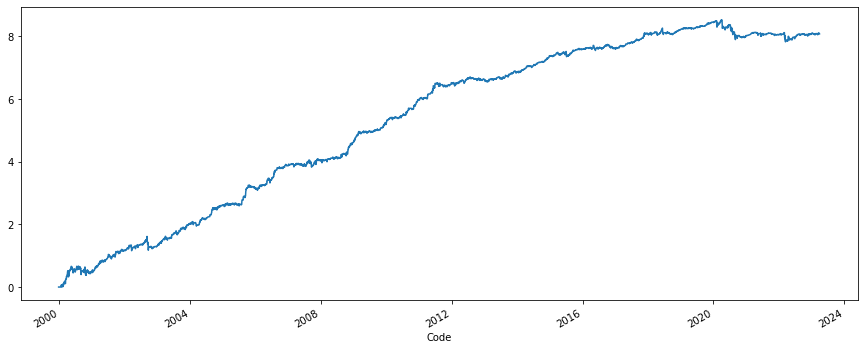

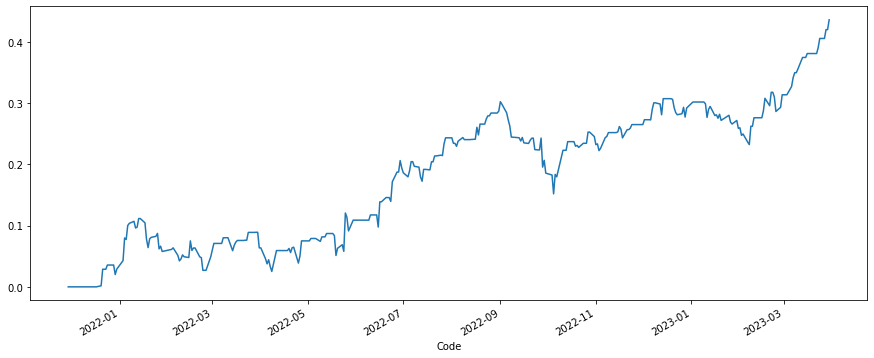

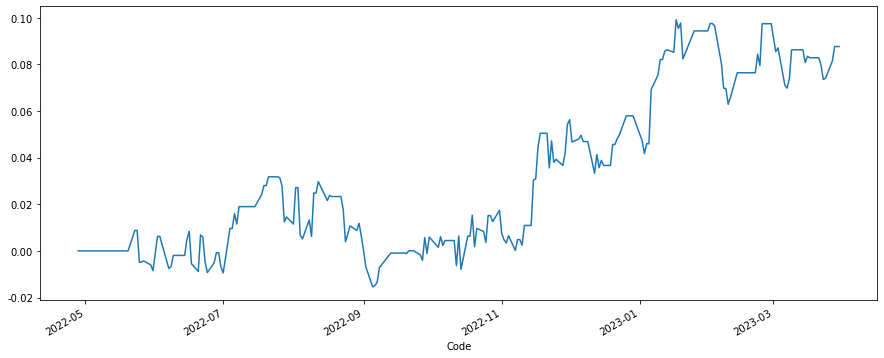

['SK우', 'DL이앤씨2우(전환)']

03473K   -0.4975
37550L    0.4975
Name: 2023-03-30 00:00:00, dtype: float64

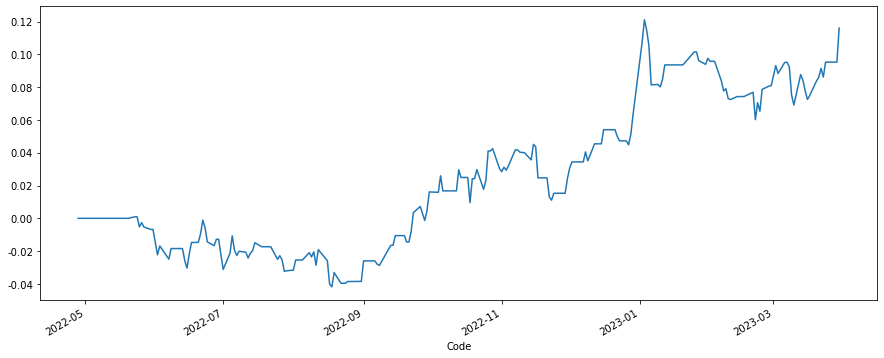

['NAVER', 'SK아이이테크놀로지']

035420    0.4975
361610   -0.4975
Name: 2023-03-30 00:00:00, dtype: float64

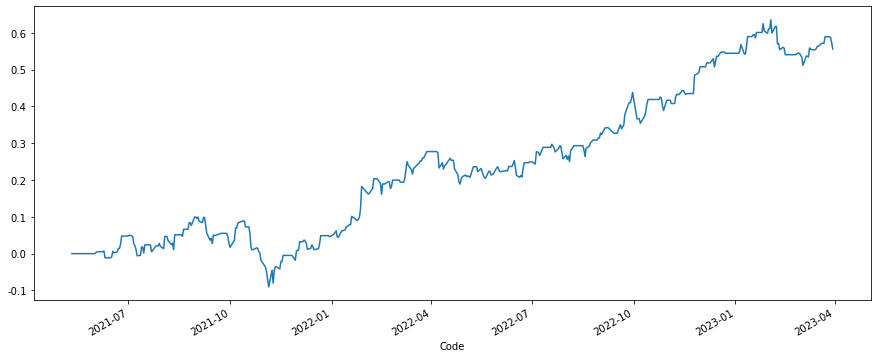

['NAVER', '카카오페이']

035420   -0.4975
377300    0.4975
Name: 2023-03-30 00:00:00, dtype: float64

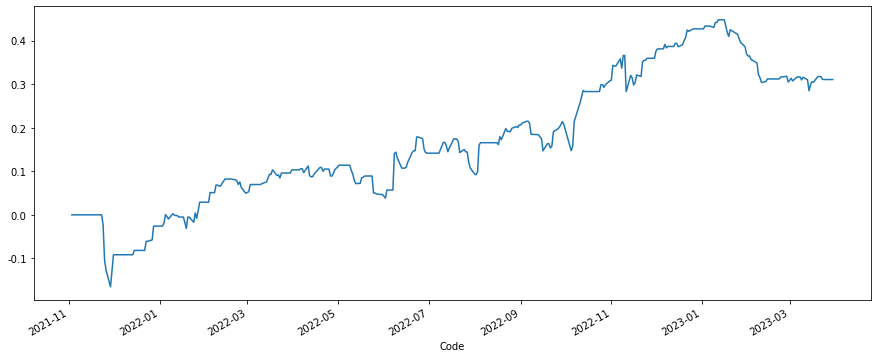

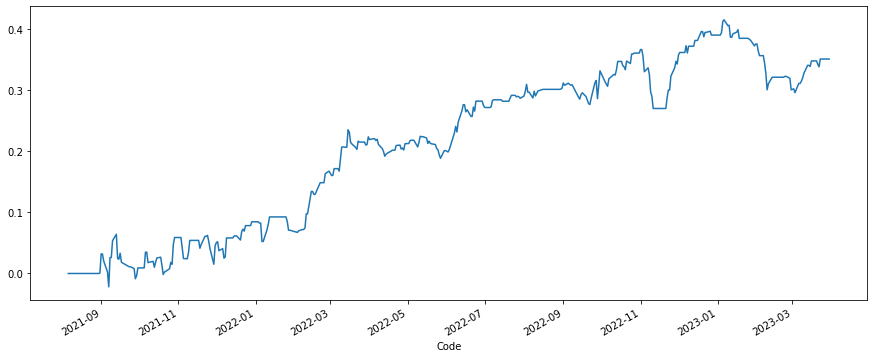

['카카오', '카카오페이']

035720   -0.4975
377300    0.4975
Name: 2023-03-30 00:00:00, dtype: float64

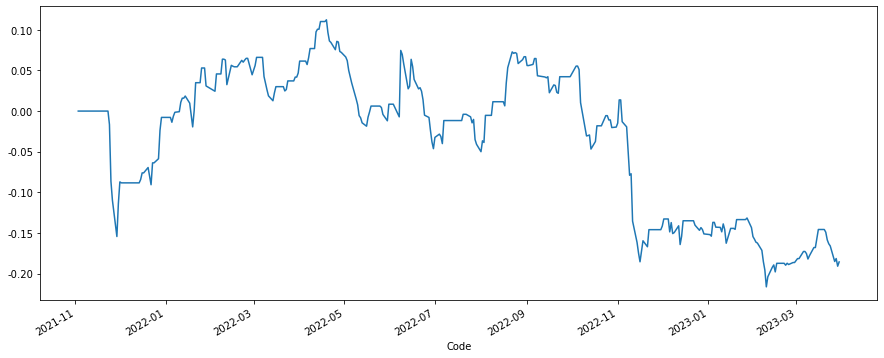

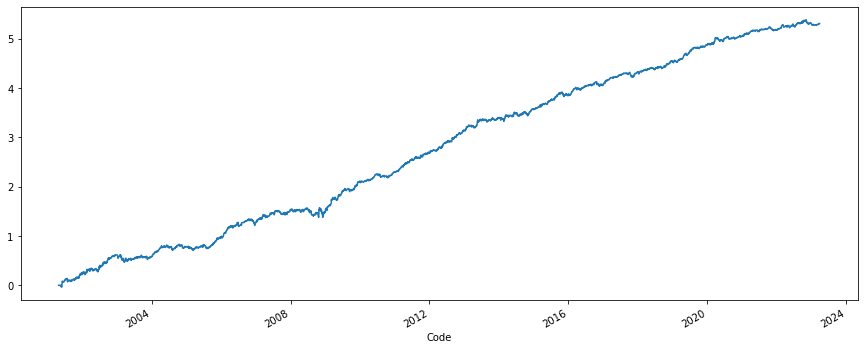

['LG생활건강우', '카카오페이']

051905    0.4975
377300   -0.4975
Name: 2023-03-30 00:00:00, dtype: float64

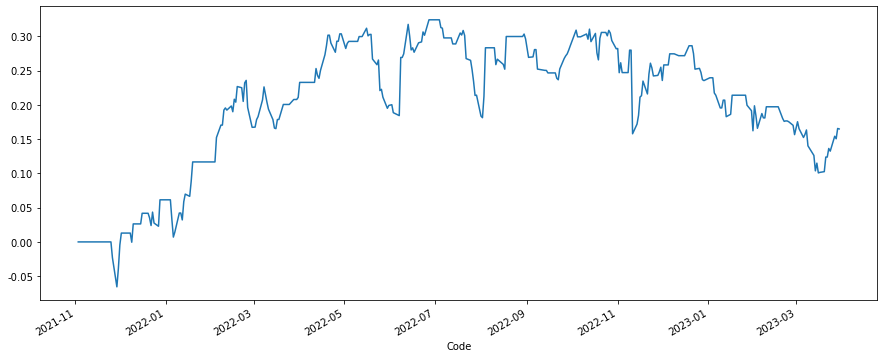

['LG생활건강우', 'SK스퀘어']

051905    0.4975
402340   -0.4975
Name: 2023-03-30 00:00:00, dtype: float64

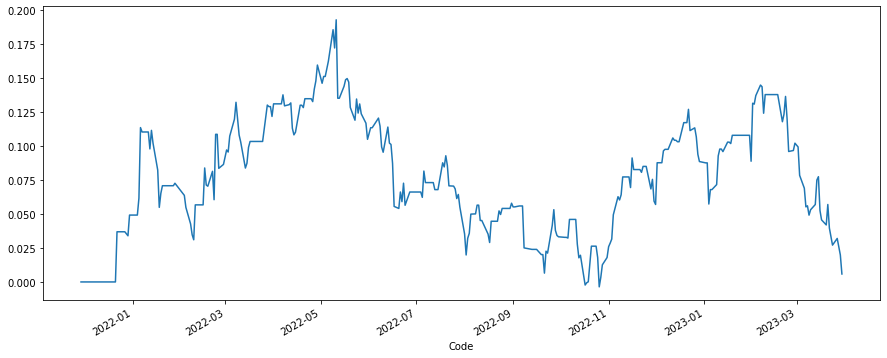

['LG화학', 'LG화학우']

051910    0.4975
051915   -0.4975
Name: 2023-03-30 00:00:00, dtype: float64

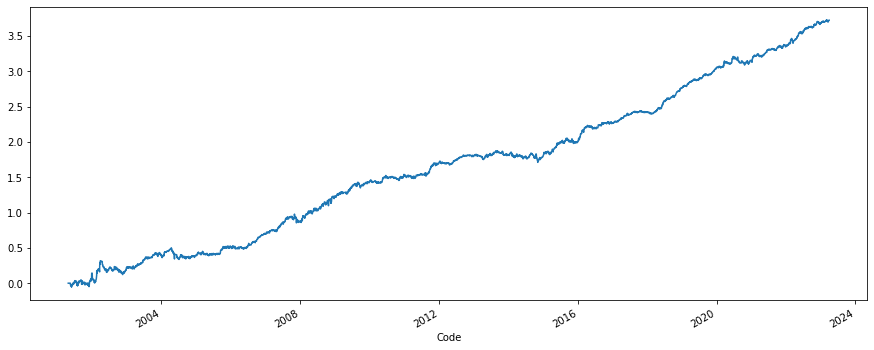

['현대홈쇼핑', 'HDC현대산업개발']

057050    0.4975
294870   -0.4975
Name: 2023-03-30 00:00:00, dtype: float64

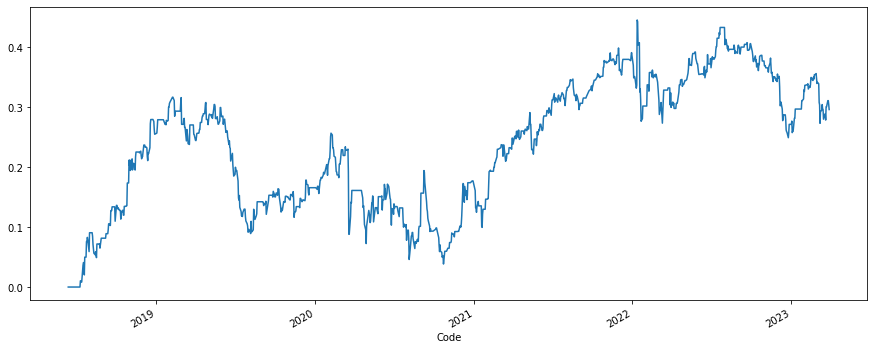

['종근당바이오', '카카오뱅크']

063160   -0.4975
323410    0.4975
Name: 2023-03-30 00:00:00, dtype: float64

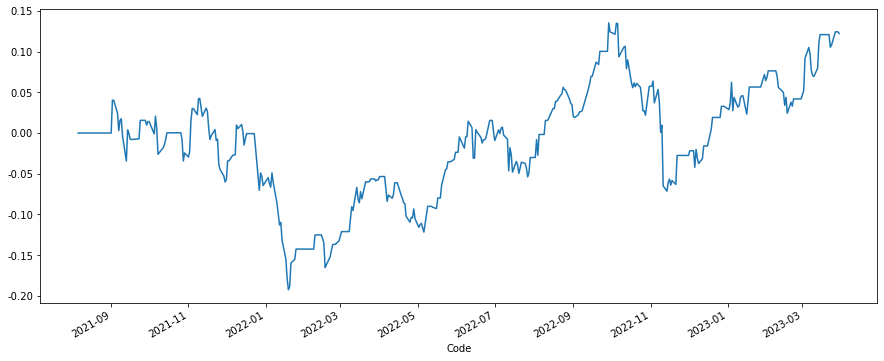

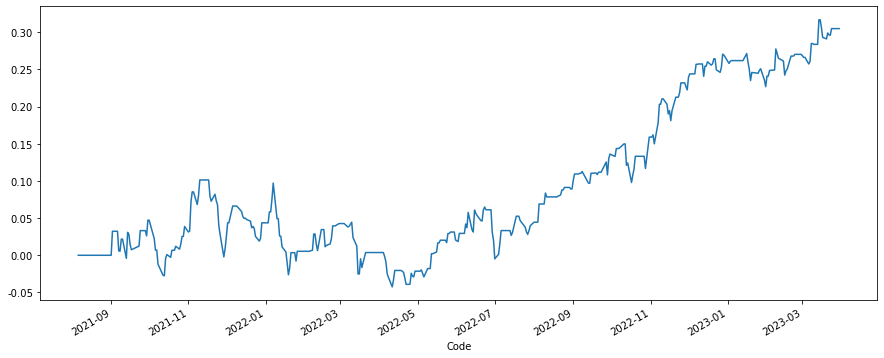

['한국금융지주우', 'DL이앤씨2우(전환)']

071055    0.4975
37550L   -0.4975
Name: 2023-03-30 00:00:00, dtype: float64

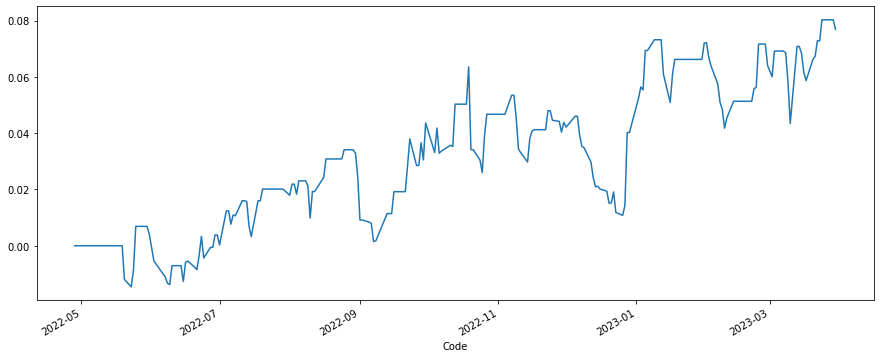

['아모레퍼시픽', '아모레퍼시픽우']

090430   -0.4975
090435    0.4975
Name: 2023-03-30 00:00:00, dtype: float64

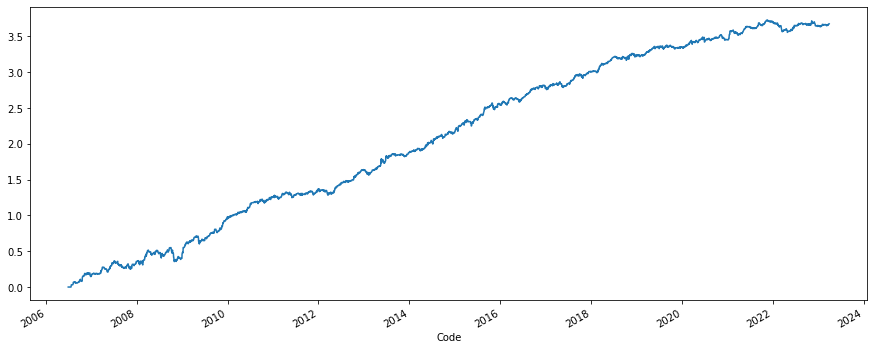

['효성ITX', '카카오뱅크']

094280   -0.4975
323410    0.4975
Name: 2023-03-30 00:00:00, dtype: float64

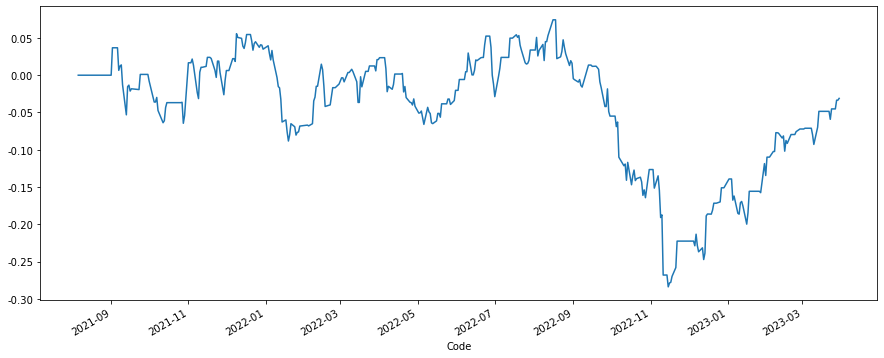

['코오롱인더우', 'DL이앤씨2우(전환)']

120115   -0.4975
37550L    0.4975
Name: 2023-03-30 00:00:00, dtype: float64

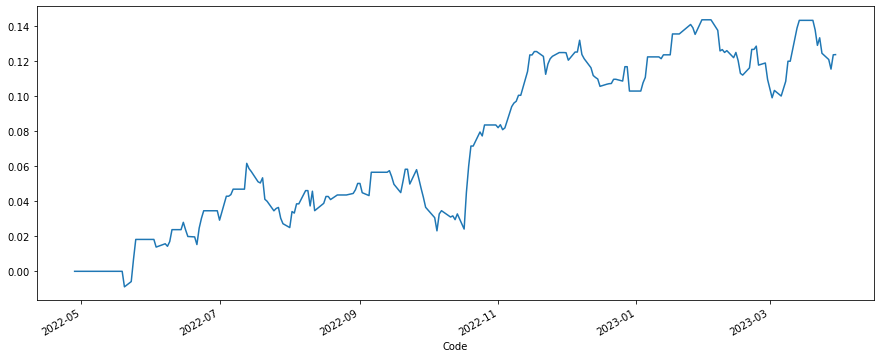

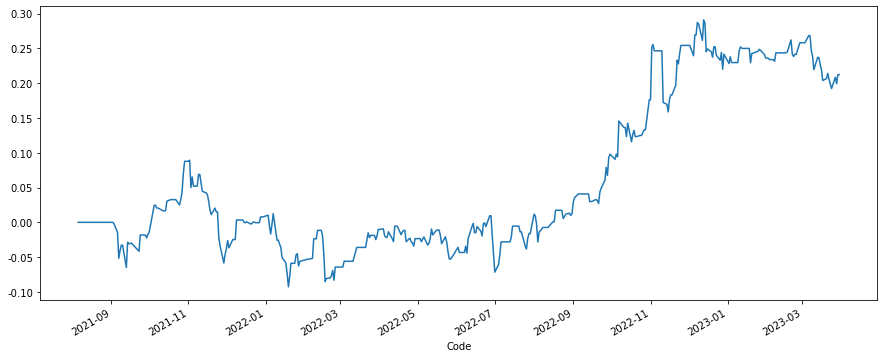

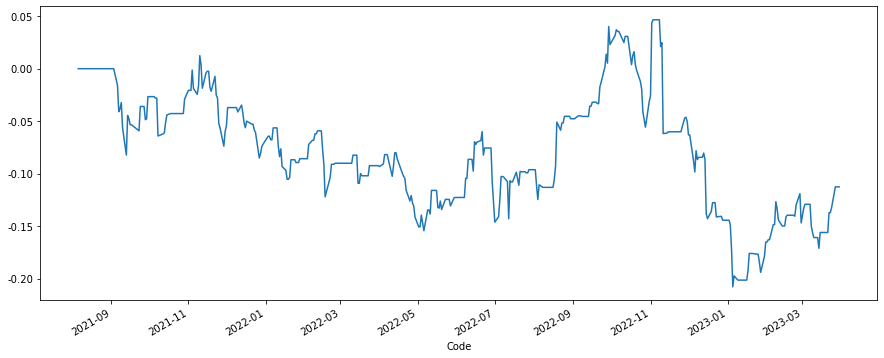

['넷마블', '카카오페이']

251270   -0.4975
377300    0.4975
Name: 2023-03-30 00:00:00, dtype: float64

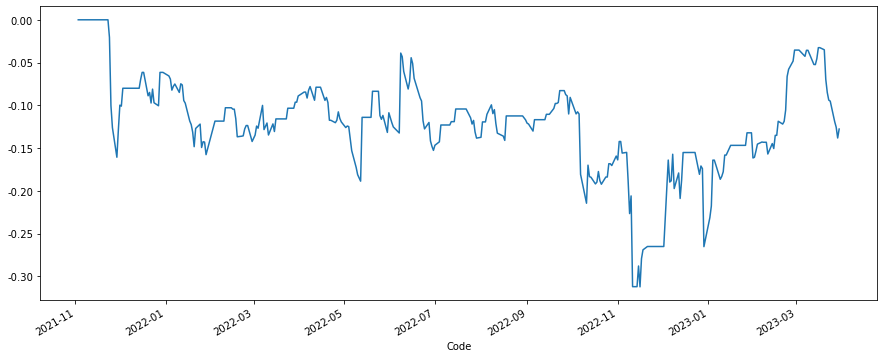

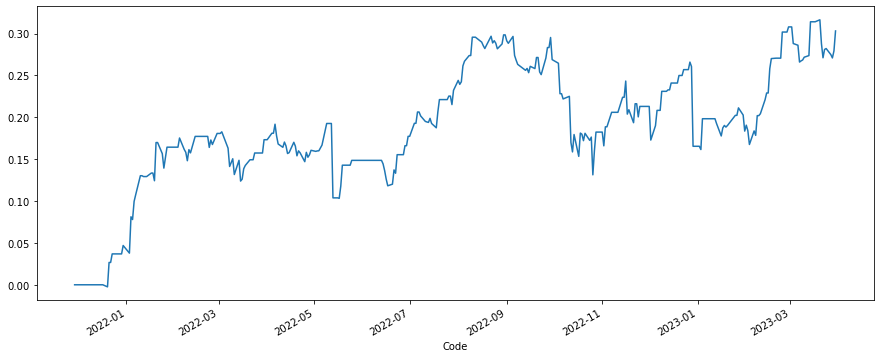

['크래프톤', 'SK바이오사이언스']

259960   -0.4975
302440    0.4975
Name: 2023-03-30 00:00:00, dtype: float64

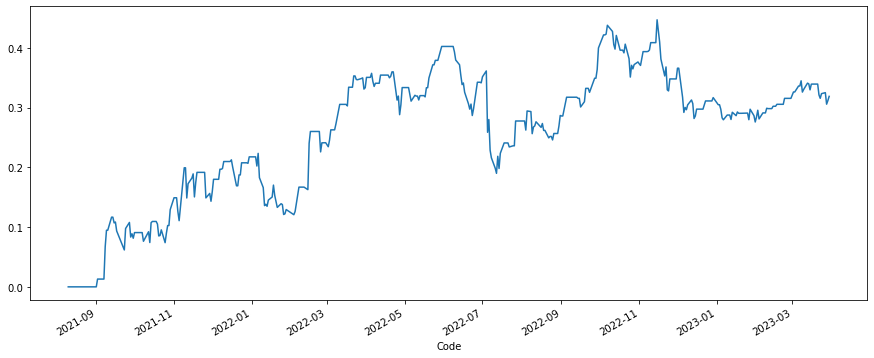

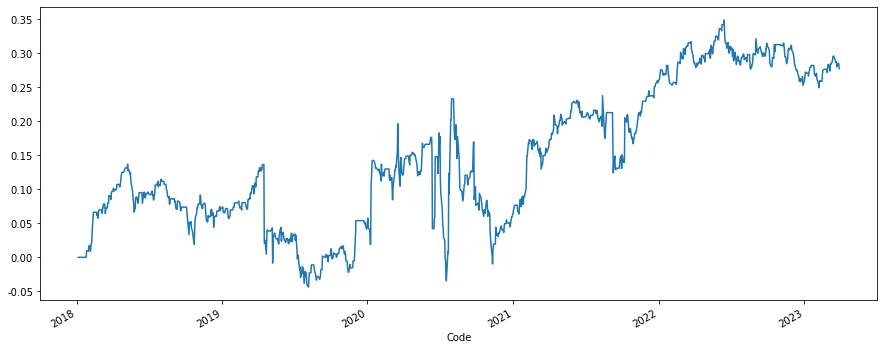

['SK케미칼우', 'DL이앤씨2우(전환)']

28513K   -0.4975
37550L    0.4975
Name: 2023-03-30 00:00:00, dtype: float64

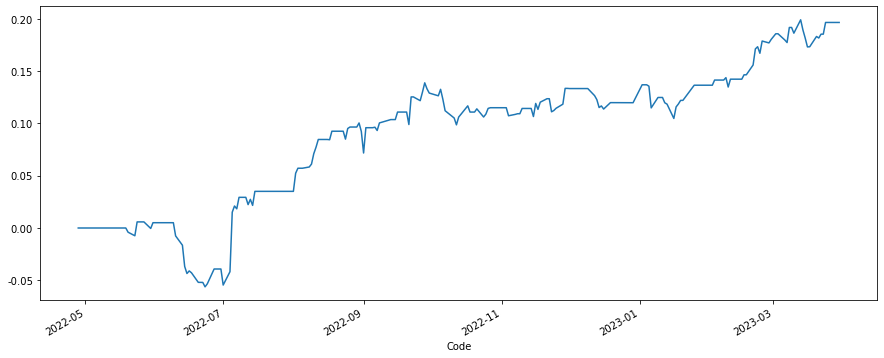

['카카오게임즈', '카카오페이']

293490   -0.4975
377300    0.4975
Name: 2023-03-30 00:00:00, dtype: float64

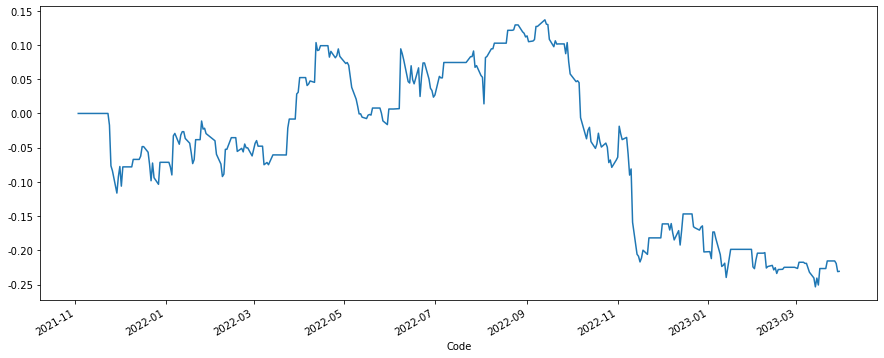

['카카오뱅크', 'SK바이오팜']

323410    0.4975
326030   -0.4975
Name: 2023-03-30 00:00:00, dtype: float64

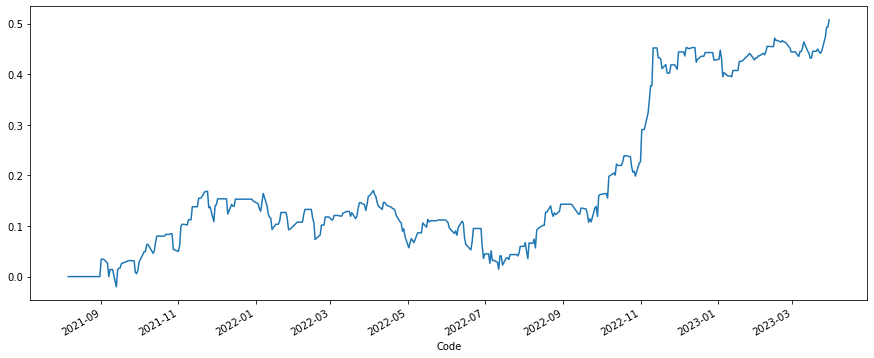

['카카오뱅크', 'SK아이이테크놀로지']

323410    0.4975
361610   -0.4975
Name: 2023-03-30 00:00:00, dtype: float64

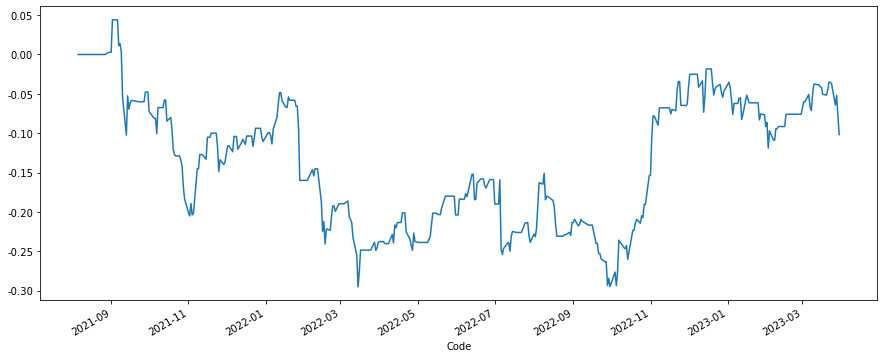

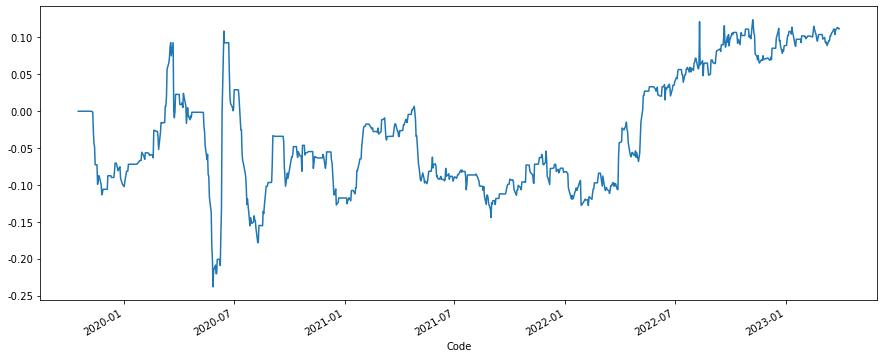

['하이브', '카카오페이']

352820   -0.4975
377300    0.4975
Name: 2023-03-30 00:00:00, dtype: float64

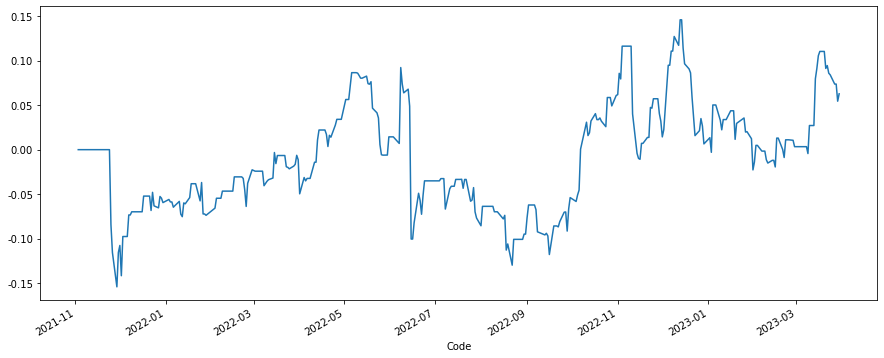

['DL이앤씨', 'DL이앤씨우']

375500   -0.4975
37550K    0.4975
Name: 2023-03-30 00:00:00, dtype: float64

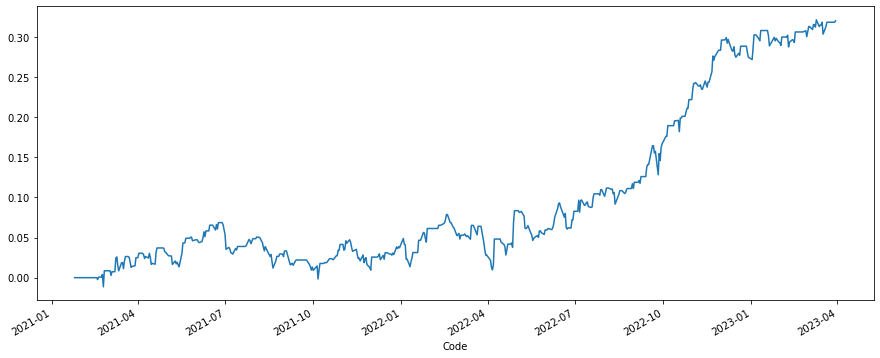

['DL이앤씨우', 'DL이앤씨2우(전환)']

37550K    0.4975
37550L   -0.4975
Name: 2023-03-30 00:00:00, dtype: float64

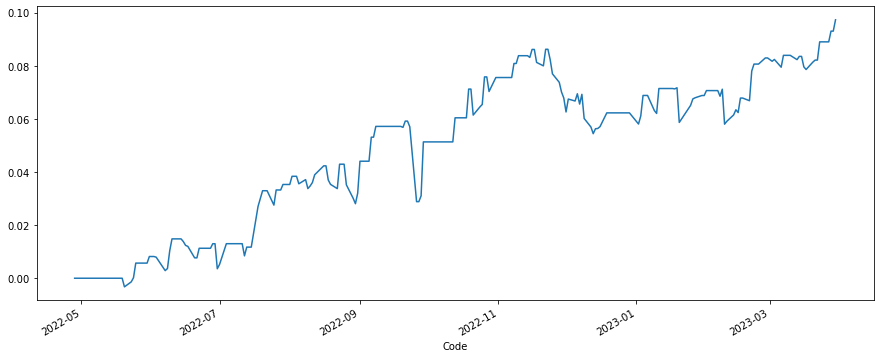

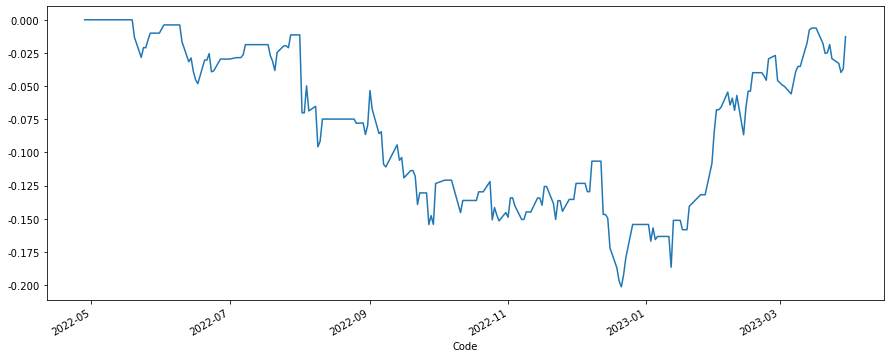

In [46]:
for i in res_df['Pair_code']:
    temp = df2[i]
    temp = temp.dropna()
    predicted_diff = kf(temp)
    #plot_predicted(predicted_diff)
    total, units = ls_backtest(temp,predicted_diff, 15, 0.5,2.5)
    total.plot(figsize=(15,6))
    if list(units.iloc[-1]) != [0,0]:
        display([Code_name[j] for j in i], units.iloc[-1])
    plt.show()

In [33]:
df2

000080  000085   000087  000090   000100   000105   000107  \
Code                                                                      
1999-12-28   3930.0  2300.0      NaN     NaN   2728.0   1723.0  47597.0   
2000-01-04   4515.0  2645.0      NaN     NaN   2951.0   1719.0  54728.0   
2000-01-05   4190.0  2550.0      NaN     NaN   2896.0   1715.0  62191.0   
2000-01-06   4200.0  2520.0      NaN     NaN   2707.0   1677.0  67995.0   
2000-01-07   4000.0  2480.0      NaN     NaN   2833.0   1769.0  62191.0   
...             ...     ...      ...     ...      ...      ...      ...   
2023-03-24  21350.0     NaN  16100.0     NaN  50500.0  50000.0      NaN   
2023-03-27  21500.0     NaN  16080.0     NaN  50500.0  50300.0      NaN   
2023-03-28  22000.0     NaN  16080.0     NaN  50600.0  50200.0      NaN   
2023-03-29  21900.0     NaN  16100.0     NaN  50400.0  49800.0      NaN   
2023-03-30  22000.0     NaN  16000.0     NaN  50100.0  49950.0      NaN   

             000120   000140   000145  ...   375500   37550K   37550L  \
Code                                   ...                              
1999-12-28  31079.0  41549.0  11203.0  ...      NaN      NaN      NaN   
2000-01-04  34118.0  37917.0  11309.0  ...      NaN      NaN      NaN   
2000-01-05  34808.0  37917.0  11309.0  ...      NaN      NaN      NaN   
2000-01-06  32875.0  36315.0  11523.0  ...      NaN      NaN      NaN   
2000-01-07  33703.0  35033.0  10883.0  ...      NaN      NaN      NaN   
...             ...      ...      ...  ...      ...      ...      ...   
2023-03-24  78400.0   9100.0  13160.0  ...  31500.0  19220.0  22050.0   
2023-03-27  77400.0   9000.0  13390.0  ...  31150.0  18850.0  21750.0   
2023-03-28  78000.0   9030.0  13190.0  ...  31550.0  18960.0  21700.0   
2023-03-29  78100.0   9020.0  13250.0  ...  32050.0  19010.0  22250.0   
2023-03-30  79100.0   9250.0  13350.0  ...  32350.0  19260.0  22350.0   

             377300   381970    383220   402340  452260  45226K  453340  
Code                                                                     
1999-12-28      NaN      NaN       NaN      NaN     NaN     NaN     NaN  
2000-01-04      NaN      NaN       NaN      NaN     NaN     NaN     NaN  
2000-01-05      NaN      NaN       NaN      NaN     NaN     NaN     NaN  
2000-01-06      NaN      NaN       NaN      NaN     NaN     NaN     NaN  
2000-01-07      NaN      NaN       NaN      NaN     NaN     NaN     NaN  
...             ...      ...       ...      ...     ...     ...     ...  
2023-03-24  57500.0  12210.0  134400.0  37500.0     NaN     NaN     NaN  
2023-03-27  54700.0  12130.0  136000.0  36900.0     NaN     NaN     NaN  
2023-03-28  55100.0  12270.0  139500.0  37350.0     NaN     NaN     NaN  
2023-03-29  53800.0  12510.0  138000.0  38050.0     NaN     NaN     NaN  
2023-03-30  54100.0  11970.0  138000.0  39300.0     NaN     NaN     NaN  

[5740 rows x 400 columns]

In [13]:
for i in res_df.sort_values(['Mdd','IR'],ascending=False).head(80)["Pair_code"]:
    temp_name = []
    for j in i:
        temp_name.append(Code_name[j])
    print(temp_name)

['한국금융지주우', 'DL이앤씨2우(전환)']
['DL이앤씨우', 'DL이앤씨2우(전환)']
['신세계푸드', 'DL이앤씨2우(전환)']
['코오롱인더우', 'DL이앤씨2우(전환)']
['하이트진로', 'DL이앤씨2우(전환)']
['아모레G', '아모레G3우(전환)']
['SK우', 'DL이앤씨2우(전환)']
['DL이앤씨', 'DL이앤씨우']
['GS건설', 'DL이앤씨우']
['카카오', '카카오뱅크']
['GS건설', 'DL이앤씨']
['하이트진로홀딩스', 'DL이앤씨2우(전환)']
['SK케미칼우', 'DL이앤씨2우(전환)']
['미래에셋증권2우B', 'SK스퀘어']
['한화투자증권', 'SK스퀘어']
['현대차우', '현대차2우B']
['한화투자증권우', 'SK스퀘어']
['SK디스커버리우', 'SK케미칼우']
['아모레G우', '아모레퍼시픽']
['LG생활건강', 'LG생활건강우']
['한화', '한화3우B']
['하이트진로홀딩스', '하이트진로홀딩스우']
['SK디스커버리우', '일진하이솔루스']
['아모레G', '아모레G우']
['한국금융지주', '카카오뱅크']
['카카오뱅크', 'SK바이오팜']
['DL이앤씨2우(전환)', '케이카']
['LG생활건강우', '카카오페이']
['NAVER', 'SK아이이테크놀로지']
['CJ씨푸드1우', 'DL이앤씨']
['LG화학', 'LG화학우']
['아모레G', '아모레퍼시픽우']
['현대차2우B', '현대차3우B']
['롯데에너지머티리얼즈', 'SK스퀘어']
['LG생활건강우', 'SK스퀘어']
['삼성SDI', '삼성SDI우']
['크래프톤', 'SK바이오사이언스']
['현대차우', '현대차3우B']
['한샘', 'SK아이이테크놀로지']
['현대홈쇼핑', 'HDC현대산업개발']
['보령', 'NAVER']
['넷마블', 'SK스퀘어']
['NAVER', '카카오페이']
['아모레퍼시픽', '아모레퍼시픽우']
['현대차', '현대모비스']
['아모레G우', '아모레퍼시픽우']
['하이브', '카카오페이'

In [ ]:
# 시가총액 천억이상
market_cap = list(stock.get_market_cap("20230329")['시가총액'][stock.get_market_cap("20230329")['시가총액']>100000000000].index)

# 스팩 제외
stock_name = [(i,stock.get_market_ticker_name(i)) for i in df_krx.columns]
except_spac = [stock[0] for stock in stock_name if "스팩" not in stock[1]]

#상장한지 2년이하 제외
except_short_term = list(df_krx.columns[df_krx.notna().sum() >= 500])

# list1과 list2에서 겹치는 부분을 찾습니다.
intersection = list(set(market_cap) & set(except_spac))

# intersection과 list3에서 겹치는 부분을 찾습니다.
selected_df = list(set(intersection) & set(except_short_term))


krx_df = df_krx[selected_df]

### parameter 를 어떻게 설정해야할지 가이드라인 제시

In [ ]:
'''res = []

for i in ls_stocks:
    tickers = i
    try:
        temp = krx_df[i].dropna()
        cor = temp.corr().iloc[0,1]
        statistic, pvalue, _ = coint(temp.iloc[:,0], temp.iloc[:,1])
        
        total, window, open_p, close_p = ls_backtest_add_parameter(temp)
        total.plot(figsize=(15,6))
        plt.show()
        
        res.append([i,window, open_p, close_p, cor, pvalue, (total.iloc[-1]+1)**(1/((total.index[-1] -total.index[0]).days/365))-1])
    except:
        pass
'''


In [ ]:
res_df = pd.DataFrame(sorted(res , key = lambda x : x[6], reverse =True))

In [ ]:
res_df.mean()

In [ ]:
if __name__ == "__main__":
#     tickers = ["005930.KS",'005935.KS']
#     df = yf.download(tickers,'2016-2-1','2023-3-24')['Adj Close']
    df= df2[["003670", "006400"]]
    df = df.dropna()
    predicted_diff = kf(df)
    plot_predicted(predicted_diff)
    total, _= ls_backtest(df,predicted_diff, 10, 1,2)
    total.plot(figsize=(15,6))

### 이제 추가해야할 부분

### KOSPI200에서 매일 포지션 시그널이 뜨게끔.
### 근데 거래대금이 작은애들은 못함
### 그리고 최근 상장한 기술주 애들이 많고 성과가 별로임.